# ANN + GMM Ensemble Model
## Chester 202018020317

# 1. Import Libraries

In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import glob
from PIL import Image
import os
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from collections import Counter
import shap

# 2. Tools Preparation

## 2.1 ReLU Activation Function
This is a custom ReLU activation function that returns the maximum of 0 and the input value.
The reason for using this custom activation function is that the GMM model requires the input to be non-negative.
The formula is as follows:
$$
f(x)=\max (0, x)
$$

Where:
- $x$ is the input value
- $f(x)$ is the output value

In [2]:
def relu(x):
    """
    Custom ReLU activation function
    :param x: input value
    :return: output value
    """
    return tf.maximum(0.0, x)

## 2.2 Swish Activation Function
This is a custom swish activation function that returns the swish of the input value.
The formula is as follows:
$$
\[
f(x)=x \cdot \sigma(x)
\]
$$

Where:
- $x$ is the input value
- $f(x)$ is the output value
- $\sigma(x)$ is the sigmoid function

In [3]:
def swish(x):
    """
    Custom swish activation function
    :param x: input value
    :return: output value
    """
    return x * tf.sigmoid(x)

## 2.3 ELU Activation Function
This is a custom ELU activation function that returns the ELU of the input value.
The formula is as follows:
$$
\[
f(x)=\left\{\begin{array}{ll}
x & \text { if } x \geq 0 \\
\alpha\left(e^{x}-1\right) & \text { if } x<0
\end{array}\right.
\]
$$

Where:
- $x$ is the input value
- $f(x)$ is the output value

In [4]:
def elu(x, alpha=1.0):
    """
    Custom ELU activation function
    :param x: input value
    :param alpha: alpha value
    :return: output value
    """
    return tf.where(x >= 0.0, x, alpha * (tf.exp(x) - 1))

## 2.4 softmax Activation Function
This is a custom softmax activation function that returns the softmax of the input value.
The reason for using this custom activation function is that the GMM model requires the input to be non-negative.
The formula is as follows:
$$
\[
\sigma(\mathbf{z})_{j}=\frac{e^{z_{j}}}{\sum_{k=1}^{K} e^{z_{k}}}
\]
$$

Where:
- $z$ is the input value
- $j$ is the $j$-th element of the input value
- $K$ is the number of elements in the input value

In [5]:
def softmax(x):
    """
    Custom softmax activation function
    :param x: input value
    :return: output value
    """
    return tf.exp(x) / tf.reduce_sum(tf.exp(x))

## 2.5 Categorical Cross Entropy Loss Function
This is a custom loss function that calculates the loss of the model's predictions.
The formula is as follows:
$$
\[
L = -\sum_{c=1}^{M} y_{\text{true}, c} \cdot \log(y_{\text{pred}, c})
\]
$$

Where:
- $M$ is the number of classes
- $y_{\text{true}, c}$ is the true label of the $c$-th class
- $y_{\text{pred}, c}$ is the predicted label of the $c$-th class

In [6]:
def categorical_Entropy_Loss_Function(y_true, y_pred):
    """
    Custom loss function
    :param y_true: true labels
    :param y_pred: predicted labels
    :return: loss
    """
    return -tf.reduce_mean(y_true * tf.math.log(y_pred))

## 2.6 Hinge Loss Function
This is a custom loss function that calculates the loss of the model's predictions.
The formula is as follows:
$$
\[
L = \max(0, 1 - y_{\text{true}} \cdot y_{\text{pred}})
\]
$$

Where:
- $y_{\text{true}}$ is the true label
- $y_{\text{pred}}$ is the predicted label
- $L$ is the loss

In [7]:
def hinge_Loss_Function(y_true, y_pred):
    """
    Custom loss function
    :param y_true: true labels
    :param y_pred: predicted labels
    :return: loss
    """
    return tf.reduce_mean(tf.maximum(0.0, 1 - y_true * y_pred))

## 2.7 Label Smoothing Cross-Entropy Loss Function
This is a custom loss function that calculates the loss of the model's predictions.
The formula is as follows:
$$
\[
L = -\sum_{c=1}^{M} y_{\text{true}, c} \cdot \log(y_{\text{pred}, c})
\]
$$

Where:
- $M$ is the number of classes
- $y_{\text{true}, c}$ is the true label of the $c$-th class
- $y_{\text{pred}, c}$ is the predicted label of the $c$-th class
- $L$ is the loss

In [8]:
def label_smoothing(y_true, y_pred, label_smoothing=0.1):
    """
    Custom loss function
    :param y_true: true labels
    :param y_pred: predicted labels
    :param label_smoothing: label smoothing factor
    :return: loss
    """
    y_true = y_true * (1.0 - label_smoothing) + 0.5 * label_smoothing
    return -tf.reduce_mean(y_true * tf.math.log(y_pred))

## 2.8 Custom Accuracy Function
This is a custom accuracy function that calculates the accuracy of the model's predictions.
The formula is as follows:
$$
\[
\text{Accuracy} = \frac{1}{N} \sum_{i=1}^{N} \mathbb{1}(y_{\text{true}, i} = y_{\text{pred}, i})
\]

$$

Where:
- $N$ is the number of samples
- $y_{\text{true}, i}$ is the true label of the $i$-th sample
- $y_{\text{pred}, i}$ is the predicted label of the $i$-th sample
- $\mathbb{1}(x)$ is the indicator function, which is 1 if $x$ is true and 0 otherwise

In [9]:
def accuracy(y_true, y_pred):
    """
    Custom accuracy function
    :param y_true: true labels
    :param y_pred: predicted labels
    :return: accuracy
    """
    correct_predictions = tf.equal(tf.argmax(y_true, axis=1), tf.argmax(y_pred, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

# 3. Model Definition

## 3.1 ANN Model
This ANN model performs the classification task by learning the complex mapping relationship between the input car label images) and the categories of the output car labels. This ANN is designed to have multiple hidden layers with multiple neurons per hidden layer (these two parameters can be changed while building the model). It is responsible for extracting features from the input image and mapping these features to the output layer, where each neuron in the output layer represents the predicted probability of a category. Since the ANN knowledge integrates a part of the model, the output of the ANN (feature vector) is not used directly for classification decisions but as input to the GMM.

In [10]:
class ANNClassifier:
    def __init__(self, input_shape, num_classes, hidden_layers_sizes):
        """
        The constructor of the ANNClassifier class.
        :param input_shape: The shape of the input data
        :param num_classes: The number of classes
        :param hidden_layers_sizes: The sizes of the hidden layers
        """
        self.model = Sequential()
        self.model.add(Flatten(input_shape=input_shape))
        for i, layer_size in enumerate(hidden_layers_sizes):
            if i % 2 == 0:
                self.model.add(Dense(layer_size, activation=swish))
            else:
                self.model.add(Dense(layer_size, activation='elu'))
        self.model.add(Dense(num_classes, activation=softmax))

    def compile(self, optimizer):
        """
        Compiles the model.
        :param optimizer: The optimizer to use
        """
        self.model.compile(optimizer=optimizer, loss=categorical_Entropy_Loss_Function, metrics=[accuracy])

    def fit(self, X, y, epochs, batch_size, validation_data):
        """
        Fits the model to the training data.
        :param X: the training data
        :param y: the training labels
        :param epochs: the number of epochs
        :param batch_size: the batch size
        :param validation_data: the validation data and labels
        :return: the history of the training process
        """
        self.history = self.model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_data=validation_data)
        return self.history

    def predict(self, X):
        """
        Predicts the labels of the data.
        :param X: the data used for prediction
        :return: the predicted labels
        """
        return self.model.predict(X)

## 3.2 GMM Model
In this integrated model, the role of the GMM is to cluster the output of the ANN. Specifically, it clusters the feature vectors of the ANN output into a number of classes, each representing a set of car labels with similar features.

In [11]:
class GMMClassifier:
    def __init__(self, n_components):
        """
        The constructor of the GMMClassifier class.
        :param n_components: The number of components
        """
        self.gmm = GaussianMixture(n_components=n_components)

    def fit(self, X):
        self.gmm.fit(X)

    def predict(self, X):
        return self.gmm.predict(X)

## 3.3 Ensemble Model
This is the integrated model that combines the ANN and GMM models. It takes the ANN and GMM models as input and uses the ANN model to extract features from the input data and the GMM model to cluster the extracted features.

In [12]:
class Ensemble:
    def __init__(self, supervised_model, unsupervised_model):
        """
        The constructor of the Ensemble class.
        :param supervised_model: the supervised model - ANN
        :param unsupervised_model: the unsupervised model - GMM
        """
        self.supervised_model = supervised_model
        self.unsupervised_model = unsupervised_model

    def fit(self, X, y, epochs, batch_size, validation_data):
        """
        Fits the model to the training data.
        :param X: the training data
        :param y: the training labels
        :param epochs: the number of epochs in the ANN
        :param batch_size: the batch size in the ANN
        :return: the history of the training process
        """
        loss_history = self.supervised_model.fit(X, y, epochs, batch_size, validation_data=validation_data)
        features = self.supervised_model.predict(X)
        print(features.shape)
        self.unsupervised_model.fit(features)

        return loss_history

    def predict(self, X):
        """
        Predicts the labels of the data.
        :param X: the data used for prediction
        :return: the predicted labels
        """
        # Get ANN predictions to use as features for GMM
        predictions = self.supervised_model.predict(X)
        # Predict with GMM
        return self.unsupervised_model.predict(predictions)

# 4. Data Processing
## 4.1 Load & Preprocess Data 
This section contains the code for loading and preprocessing the data.

In [13]:
def load_images(image_paths, target_size):
    images = []
    labels = []
    for image_path in image_paths:
        img = Image.open(image_path).convert('RGB')
        img = img.resize(target_size)
        img_array = np.array(img)
        images.append(img_array)
        label = os.path.basename(os.path.dirname(image_path))
        labels.append(label)

    # Normalize pixel values
    images = np.array(images, dtype='float32') / 255.0
    # Convert labels to integer encoding
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    # Convert labels to one-hot encoding
    labels = tf.keras.utils.to_categorical(labels)
    return images, labels


# Load images
image_paths = glob.glob('Car_Logo_Dataset/**/*.png', recursive=True)
X, y = load_images(image_paths, target_size=(32, 32))

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
print(X[1])
print(X.shape)
print(y[1])
print(y.shape)

[[[0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  ...
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]]

 [[0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  ...
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]]

 [[0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  ...
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]]

 ...

 [[0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  ...
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]]

 [[0.09019608 0.09019608 0.09019608]
  [0.09019608 0.09019608 0.09019608]


## 4.2 Data visualization

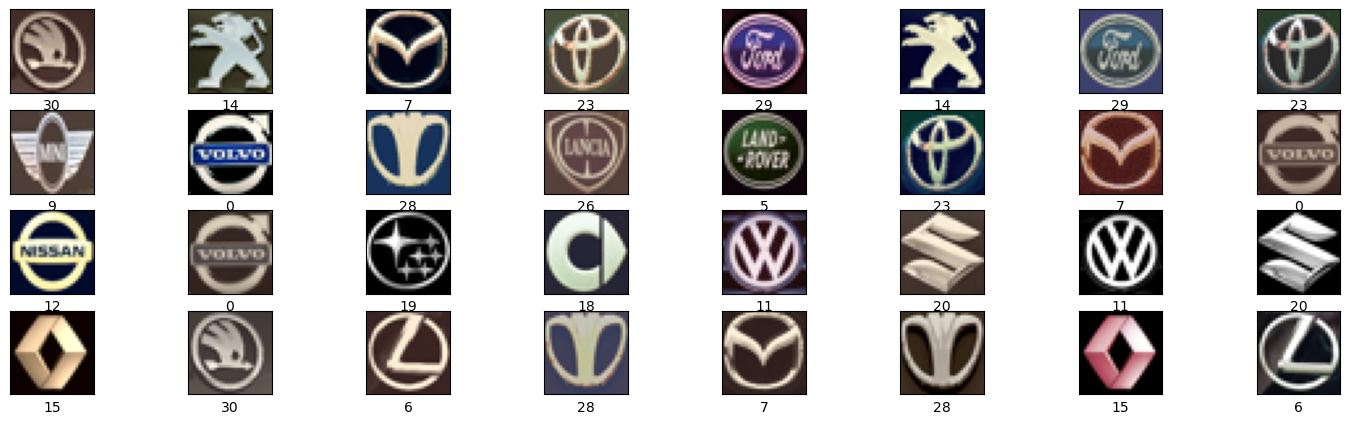

In [15]:
plt.figure(figsize=(18, 5))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(X_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(np.argmax(y_train[i]))

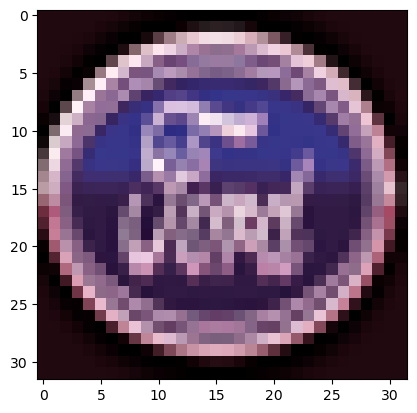

In [16]:
plt.imshow(X_train[4])

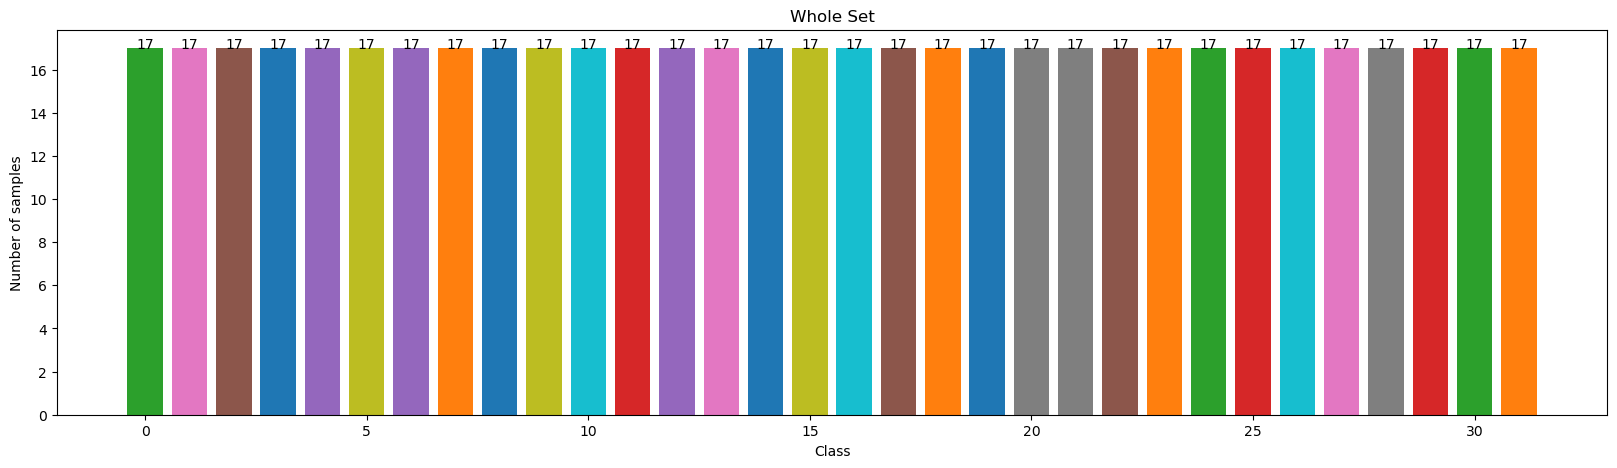

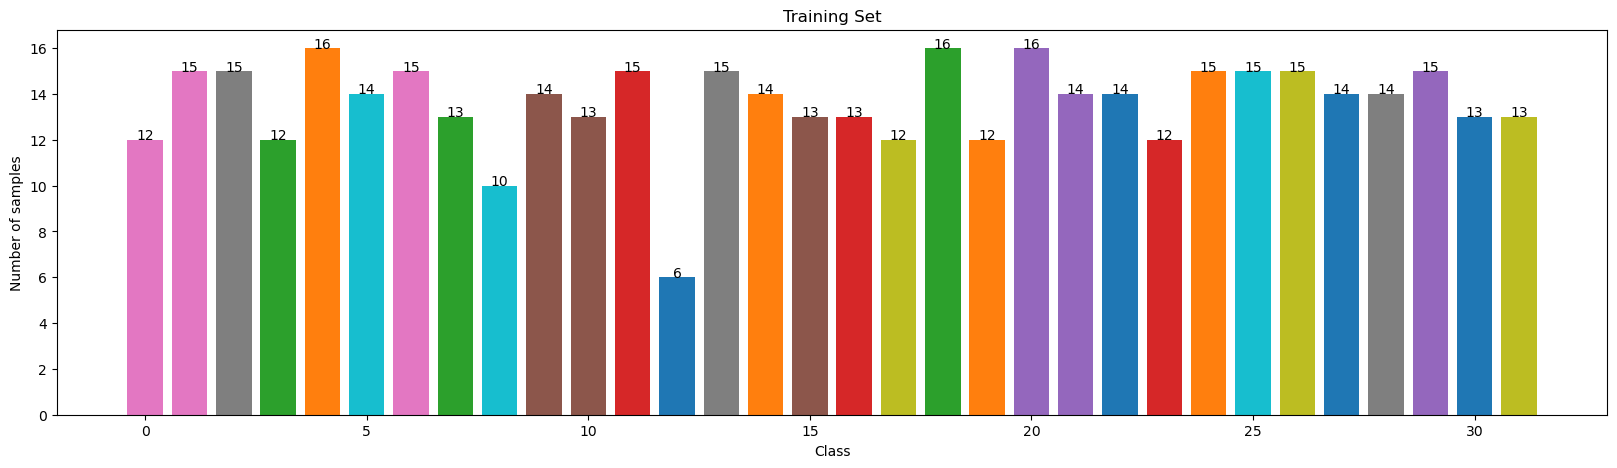

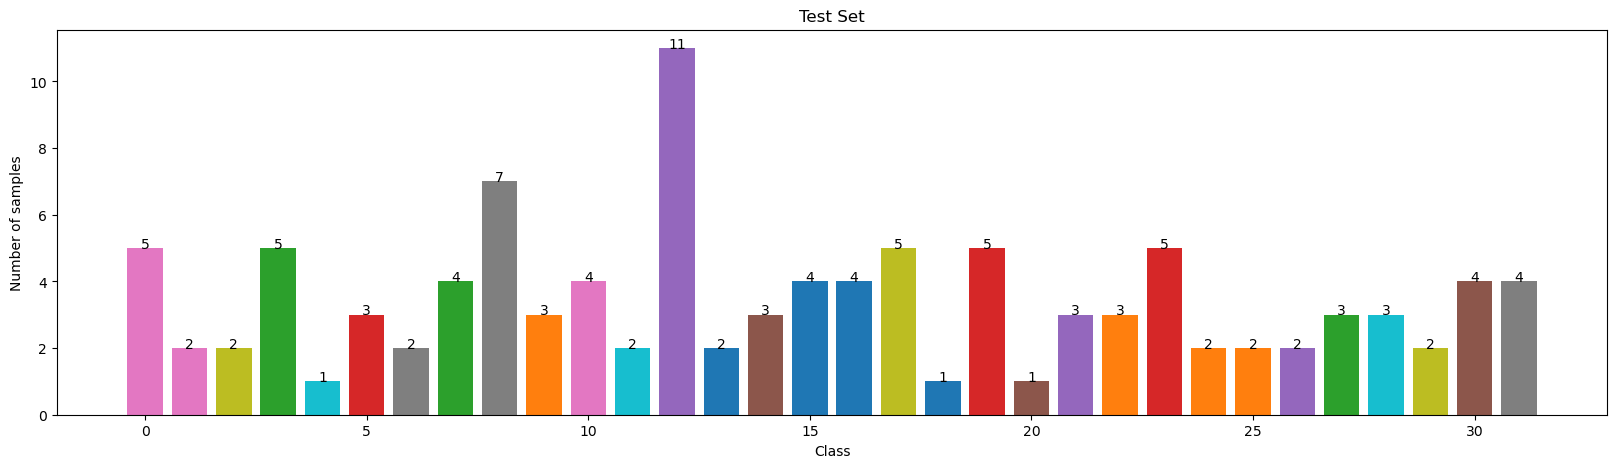

In [17]:
class DistributionPlotter:
    def __init__(self, y):
        self.y = y

    def plot(self, title=""):
        counter = Counter(self.y)
        numbers = list(counter.values())
        labels = list(counter.keys())
        colors = [f'C{i}' for i in range(len(numbers))]

        plt.figure(figsize=(20, 5))
        plt.bar(labels, numbers, color=colors)

        for i in range(len(numbers)):
            plt.text(labels[i], numbers[i], numbers[i], ha='center')

        plt.title(title)
        plt.xlabel('Class')
        plt.ylabel('Number of samples')
        plt.show()


DistributionPlotter(np.argmax(y, axis=1)).plot(title="Whole Set")
DistributionPlotter(np.argmax(y_train, axis=1)).plot(title="Training Set")
DistributionPlotter(np.argmax(y_test, axis=1)).plot(title="Test Set")

# 5. Model Building
## 5.1 Model Construction

In [18]:
ann = ANNClassifier(input_shape=X_train.shape[1:], num_classes=y_train.shape[1],
                    hidden_layers_sizes=(128, 128))
ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.009))
gmm = GMMClassifier(n_components=2)
ensemble = Ensemble(ann, gmm)

2023-12-14 13:04:23.796017: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-12-14 13:04:23.796038: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-14 13:04:23.796041: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-14 13:04:23.796089: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-14 13:04:23.796103: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## 5.2 Model Training

In [19]:
history = ensemble.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))
y_pred = ensemble.predict(X_test)
y_test = np.argmax(y_test, axis=1)

Epoch 1/40


2023-12-14 13:04:24.146351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 31ms/step - loss: 0.5889 - accuracy: 0.0894 - val_loss: 0.3637 - val_accuracy: 0.1749
Epoch 2/40
 7/14 [==============>...............] - ETA: 0s - loss: 0.3225 - accuracy: 0.1562

2023-12-14 13:04:24.711825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 12ms/step - loss: 0.2746 - accuracy: 0.2310 - val_loss: 0.1971 - val_accuracy: 0.3540
Epoch 3/40
14/14 [==============================] - 0s 12ms/step - loss: 0.1946 - accuracy: 0.4646 - val_loss: 0.1706 - val_accuracy: 0.5793
Epoch 4/40
14/14 [==============================] - 0s 12ms/step - loss: 0.1550 - accuracy: 0.8072 - val_loss: 0.1464 - val_accuracy: 0.8287
Epoch 5/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1453 - accuracy: 0.8569 - val_loss: 0.1377 - val_accuracy: 0.8209
Epoch 6/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1374 - accuracy: 0.9219 - val_loss: 0.1301 - val_accuracy: 0.9573
Epoch 7/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1286 - accuracy: 0.9754 - val_loss: 0.1202 - val_accuracy: 0.9922
Epoch 8/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1277 - accuracy: 0.9754 - val_loss: 0.1310 - val_accuracy: 0.9609
Epoch 9/40
14/14 [======

2023-12-14 13:04:31.444517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 9ms/step


# 6. Model Evaluation
## 6.1 Plot History

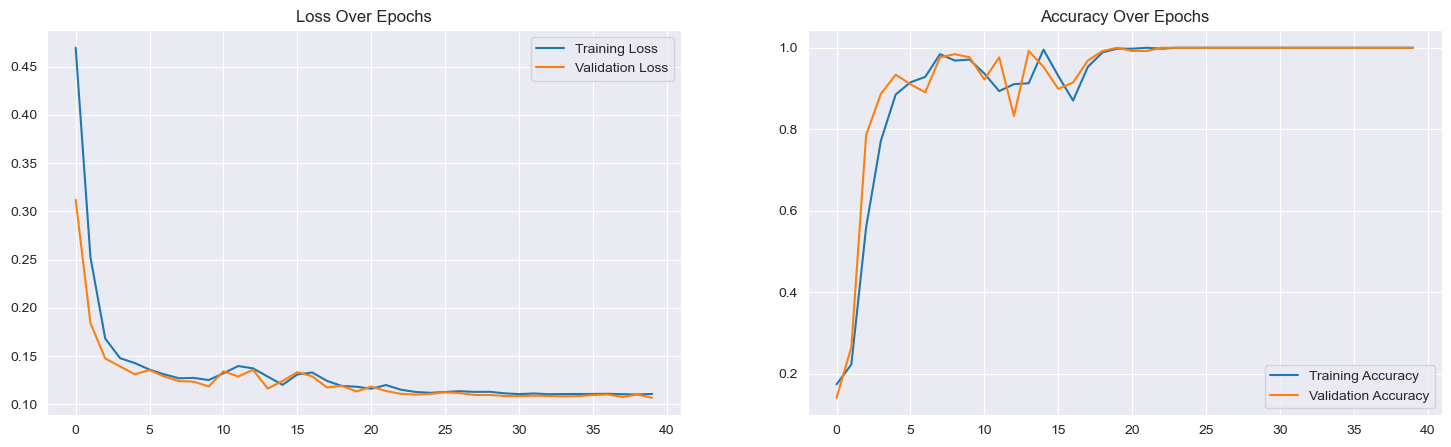

ANN Final cost: 0.11064346134662628
ANN Validation Loss: 0.10666675120592117
ANN Final accuracy: 1.0
ANN Validation accuracy: 1.0


In [20]:
def plot_history(history):
    plt.figure(figsize=(18, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()
    plt.show()


plot_history(history)
print('ANN Final cost:', history.history['loss'][-1])
print('ANN Validation Loss:', history.history['val_loss'][-1])
print('ANN Final accuracy:', history.history['accuracy'][-1])
print('ANN Validation accuracy:', history.history['val_accuracy'][-1])

## 6.2 Remap Labels
Due to the nature of the unsupervised model, the predicted labels may not be the same as the true labels. This function remaps the predicted labels to the true labels.

In [24]:
def remap_labels(true_labels, predicted_labels):
    unique_true_labels = np.unique(true_labels)
    mapped_labels = np.zeros_like(predicted_labels)

    for true_label in unique_true_labels:
        mask = (true_labels == true_label)
        predicted_labels_for_true_label = predicted_labels[mask]
        unique_predicted, counts = np.unique(predicted_labels_for_true_label, return_counts=True)
        most_common = unique_predicted[np.argmax(counts)]
        mapped_labels[predicted_labels == most_common] = true_label

    return mapped_labels


mapped_predictions = remap_labels(y_test, y_pred)

In [22]:
print("True labels:")
print(y_test)
print("Predicted labels:")
print(y_pred)
print("Remapped predicted labels:")
print(mapped_predictions)

True labels:
[13 22  7 23 23 12 20 12 12  0  8  2  4 12 23  2 15 25  3 19 12 21 15  0
 30  8  1  3  8  3 12  6 12 17 19 11 15 19 21 16  9 27  5 26 16 14  9 10
  7  9 31 29 12 12  3 13  8 16 14 23 30  6 10 30 19 23 17 28  0 18 11 12
 28 10 29 12 19 25 28 17 27  3 31 10  5  8  8 22 31  7  0 17  1 15 22 21
  7  0 31 30  5  8 14 24 16 27 24 17 26]
Predicted labels:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1]
Remapped predicted labels:
[31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 27 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 27 31 31 31 31 31 31 31 31 31 31 31 31 31 31 31
 31 31 31 31 31 31 31 31 31 27 31 31 31]


## 6.3 Confusion Matrix

Classify Report of Ensemble Model
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       0.00       0.00       0.00       0.50          5
         2       0.00       0.00       0.00       0.50          2
         3       0.00       0.00       0.00       0.50          2
         4       0.00       0.00       0.00       0.50          5
         5       0.00       0.00       0.00       0.50          1
         6       0.00       0.00       0.00       0.50          3
         7       0.00       0.00       0.00       0.50          2
         8       0.00       0.00       0.00       0.50          4
         9       0.00       0.00       0.00       0.50          7
        10       0.00       0.00       0.00       0.50          3
        11       0.00       0.00       0.00       0.50          4
        12       0.00       0.00       0.00       0.50          2
        13       0.00       0.00       0.00       0.50         11
        14       0.00       0.00       0.0

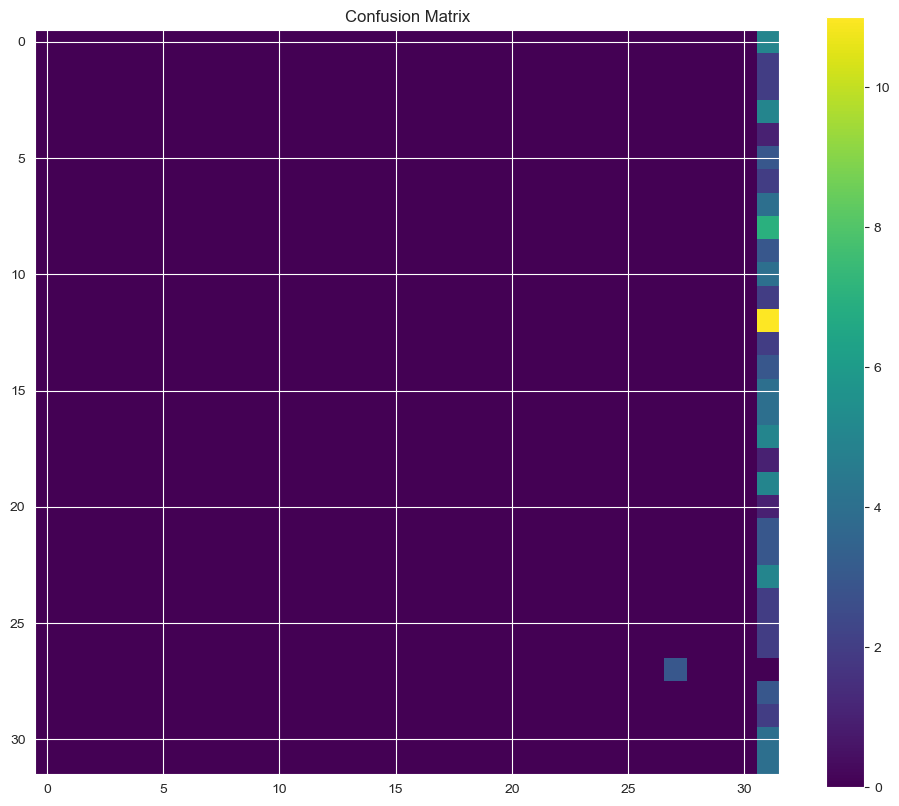

In [23]:
def ensemble_loss(y_true, y_pred_labels, num_classes):
    """
    Calculate the ensemble loss between two sequences of categorical data.
    
    :param y_true: the true labels
    :param y_pred_labels: the predicted labels
    :param num_classes: the number of classes
    :return: the loss
    """
    y_true_one_hot = np.eye(num_classes)[y_true]
    y_pred_one_hot = np.eye(num_classes)[y_pred_labels]

    loss = -np.sum(y_true_one_hot * np.log(y_pred_one_hot + 1e-15)) / len(y_true)
    return loss


def confusion_matrix(y_true, y_pred):
    """
    Compute and print the confusion matrix, classification report, and estimate ROC AUC.
    
    :param y_true: the true labels
    :param y_pred: the predicted labels
    :return: the confusion matrix
    """
    num_classes = len(np.unique(y_true))
    result = np.zeros((num_classes, num_classes))
    roc_auc_scores = np.zeros(num_classes)

    for i in range(len(y_true)):
        result[y_true[i]][y_pred[i]] += 1

    true_positive = np.diag(result)
    false_positive = np.sum(result, axis=0) - true_positive
    false_negative = np.sum(result, axis=1) - true_positive
    true_negative = np.sum(result) - (true_positive + false_positive + false_negative)

    epsilon = 1e-7
    recall = true_positive / (true_positive + false_negative + epsilon)
    precision = true_positive / (true_positive + false_positive + epsilon)
    f1_score = 2 * precision * recall / (precision + recall + epsilon)
    support = np.sum(result, axis=1)
    sensitivity = true_positive / (true_positive + false_negative + epsilon)
    specificity = true_negative / (true_negative + false_positive + epsilon)
    loss = ensemble_loss(y_true, y_pred, num_classes)
    
    
    print("Classify Report of Ensemble Model")
    print("=" * 80)
    print("{:>10} {:>10} {:>10} {:>10} {:>10} {:>10}".format('Class', 'Precision', 'Recall', 'F1-Score', 'ROC AUC', 'Support'))
    
    for i in range(num_classes):
        TPR = recall[i]
        FPR = false_positive[i] / (false_positive[i] + true_negative[i] + epsilon)
        roc_auc = (1 + TPR - FPR) / 2
        roc_auc_scores[i] = roc_auc

        print("{:>10d} {:>10.2f} {:>10.2f} {:>10.2f} {:>10.2f} {:>10d}".format(i + 1, precision[i], recall[i],
                                                                               f1_score[i], roc_auc, int(support[i])))

    print("=" * 80)
    print("Avg Recall: {:.2f}".format(np.mean(recall)))
    print("Avg Precision: {:.2f}".format(np.mean(precision)))
    print("Avg Sensitivity: {:.2f}".format(np.mean(sensitivity)))
    print("Avg Specificity: {:.2f}".format(np.mean(specificity)))
    print("Avg F1-Score: {:.2f}".format(np.mean(f1_score)))
    print("Avg ROC AUC: {:.2f}".format(np.mean(roc_auc_scores)))
    print("Loss: {:.2f}".format(loss))
    return result


conf_matrix = confusion_matrix(y_test, mapped_predictions)
plt.figure(figsize=(12, 10))
plt.imshow(conf_matrix, cmap='viridis')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

# 6.4 Accuracy
This is a custom accuracy function that calculates the accuracy of the model's predictions.
The formula is as follows:
$$
\[
\text{Accuracy} = \frac{1}{N} \sum_{i=1}^{N} \mathbb{1}(y_{\text{true}, i} = y_{\text{pred}, i})
\]

$$

Where:
- $N$ is the number of samples
- $y_{\text{true}, i}$ is the true label of the $i$-th sample
- $y_{\text{pred}, i}$ is the predicted label of the $i$-th sample

In [24]:
def custom_accuracy(y_true, y_pred):
    """
    Custom accuracy function
    :param y_true: true labels
    :param y_pred: predicted labels
    :return: accuracy
    """
    correct_predictions = tf.equal(y_true, y_pred)
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32)) * 100


print(f"Accuracy: {custom_accuracy(y_test, mapped_predictions).numpy():.3f}%")

Accuracy: 6.422%


# 6.5 Visualization

4/4 [==============================] - 0s 3ms/step


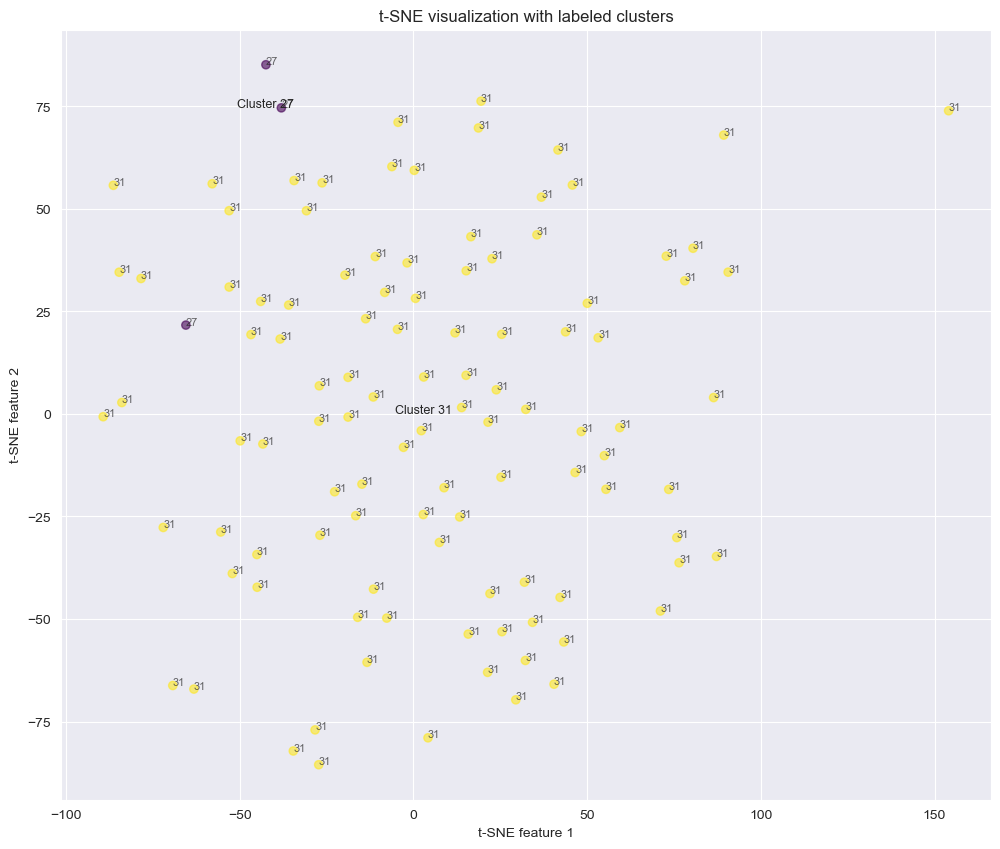

In [25]:
def visualize_clusters_with_labels(X, y, model):
    features = model.predict(X)

    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    X_reduced = tsne.fit_transform(features)

    plt.figure(figsize=(12, 10))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', alpha=0.6)

    unique_labels = np.unique(y)
    for i, label in enumerate(unique_labels):
        xtext, ytext = np.median(X_reduced[y == label, :], axis=0)
        txt = f'Cluster {label}'
        plt.annotate(txt, (xtext, ytext), fontsize=9, ha='center')

    for i, txt in enumerate(y):
        plt.annotate(txt, (X_reduced[i, 0], X_reduced[i, 1]), fontsize=8, alpha=0.7)

    plt.title('t-SNE visualization with labeled clusters')
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.show()


visualize_clusters_with_labels(X_test, mapped_predictions, ann)

# 7. Hyperparameter Test

In [43]:
image_paths = glob.glob('Car_Logo_Dataset/**/*.png', recursive=True)
X, y = load_images(image_paths, target_size=(32, 32))

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 7.1 Set different hidden layers of ANN

Epoch 1/40


2023-12-14 11:03:20.736954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.1942 - accuracy: 0.4293

2023-12-14 11:03:21.897160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 2s 72ms/step - loss: 0.1942 - accuracy: 0.4293 - val_loss: 0.1676 - val_accuracy: 0.7933
Epoch 2/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1464 - accuracy: 0.9427 - val_loss: 0.1336 - val_accuracy: 0.9141
Epoch 3/40
14/14 [==============================] - 0s 15ms/step - loss: 0.1281 - accuracy: 0.9777 - val_loss: 0.1220 - val_accuracy: 0.9922
Epoch 4/40
14/14 [==============================] - 0s 15ms/step - loss: 0.1251 - accuracy: 1.0000 - val_loss: 0.1198 - val_accuracy: 0.9922
Epoch 5/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1219 - accuracy: 1.0000 - val_loss: 0.1163 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 14ms/step - loss: 0.1196 - accuracy: 1.0000 - val_loss: 0.1156 - val_accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 13ms/step - loss: 0.1177 - accuracy: 1.0000 - val_loss: 0.1160 - val_accuracy: 0.9922
Epoch 8/40
14/14 [======

2023-12-14 11:03:29.121835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 24ms/step


Classify Report of Ensemble Model
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.0

2023-12-14 11:03:32.132463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.2046 - accuracy: 0.3099

2023-12-14 11:03:33.348110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 2s 80ms/step - loss: 0.2046 - accuracy: 0.3099 - val_loss: 0.1857 - val_accuracy: 0.5757
Epoch 2/40
14/14 [==============================] - 0s 21ms/step - loss: 0.1639 - accuracy: 0.7938 - val_loss: 0.1474 - val_accuracy: 0.8828
Epoch 3/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1353 - accuracy: 0.9688 - val_loss: 0.1277 - val_accuracy: 1.0000
Epoch 4/40
14/14 [==============================] - 0s 20ms/step - loss: 0.1269 - accuracy: 0.9933 - val_loss: 0.1214 - val_accuracy: 1.0000
Epoch 5/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1229 - accuracy: 0.9978 - val_loss: 0.1216 - val_accuracy: 0.9922
Epoch 6/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1215 - accuracy: 0.9978 - val_loss: 0.1205 - val_accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 15ms/step - loss: 0.1197 - accuracy: 1.0000 - val_loss: 0.1163 - val_accuracy: 1.0000
Epoch 8/40
14/14 [======

2023-12-14 11:03:40.902242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 24ms/step


Classify Report of Ensemble Model
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.0

2023-12-14 11:03:41.744299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.2060 - accuracy: 0.2697

2023-12-14 11:03:43.052194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 2s 86ms/step - loss: 0.2060 - accuracy: 0.2697 - val_loss: 0.1874 - val_accuracy: 0.6298
Epoch 2/40
14/14 [==============================] - 0s 26ms/step - loss: 0.1706 - accuracy: 0.7909 - val_loss: 0.1521 - val_accuracy: 0.9453
Epoch 3/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1384 - accuracy: 0.9665 - val_loss: 0.1277 - val_accuracy: 1.0000
Epoch 4/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1252 - accuracy: 1.0000 - val_loss: 0.1211 - val_accuracy: 0.9844
Epoch 5/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1217 - accuracy: 0.9933 - val_loss: 0.1181 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1192 - accuracy: 1.0000 - val_loss: 0.1135 - val_accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1169 - accuracy: 1.0000 - val_loss: 0.1126 - val_accuracy: 1.0000
Epoch 8/40
14/14 [======

2023-12-14 11:03:52.003653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 47ms/step


Classify Report of Ensemble Model
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       0.00       0.00       0.00       0.50          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       0.61       1.00       0.76       0.96         11
        14       1.00       1.00       1.0

2023-12-14 11:03:52.926777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.2076 - accuracy: 0.2734

2023-12-14 11:03:54.379851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 2s 95ms/step - loss: 0.2076 - accuracy: 0.2734 - val_loss: 0.1928 - val_accuracy: 0.3774
Epoch 2/40
14/14 [==============================] - 0s 29ms/step - loss: 0.1728 - accuracy: 0.6658 - val_loss: 0.1534 - val_accuracy: 0.7350
Epoch 3/40
14/14 [==============================] - 0s 22ms/step - loss: 0.1378 - accuracy: 0.9509 - val_loss: 0.1299 - val_accuracy: 0.9922
Epoch 4/40
14/14 [==============================] - 0s 22ms/step - loss: 0.1244 - accuracy: 0.9955 - val_loss: 0.1198 - val_accuracy: 1.0000
Epoch 5/40
14/14 [==============================] - 0s 20ms/step - loss: 0.1206 - accuracy: 0.9911 - val_loss: 0.1158 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1183 - accuracy: 1.0000 - val_loss: 0.1142 - val_accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1171 - accuracy: 1.0000 - val_loss: 0.1169 - val_accuracy: 1.0000
Epoch 8/40
14/14 [======

2023-12-14 11:04:04.128191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 13ms/step
(435, 32)
4/4 [==============================] - 0s 34ms/step


Classify Report of Ensemble Model
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.0

2023-12-14 11:04:05.098051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.2081 - accuracy: 0.1975

2023-12-14 11:04:06.421757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 2s 89ms/step - loss: 0.2081 - accuracy: 0.1975 - val_loss: 0.1956 - val_accuracy: 0.3383
Epoch 2/40
14/14 [==============================] - 0s 27ms/step - loss: 0.1806 - accuracy: 0.5384 - val_loss: 0.1702 - val_accuracy: 0.6184
Epoch 3/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1560 - accuracy: 0.7856 - val_loss: 0.1515 - val_accuracy: 0.7470
Epoch 4/40
14/14 [==============================] - 0s 20ms/step - loss: 0.1395 - accuracy: 0.9330 - val_loss: 0.1378 - val_accuracy: 0.9141
Epoch 5/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1294 - accuracy: 0.9821 - val_loss: 0.1273 - val_accuracy: 0.9141
Epoch 6/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1233 - accuracy: 0.9911 - val_loss: 0.1221 - val_accuracy: 0.9844
Epoch 7/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1200 - accuracy: 0.9978 - val_loss: 0.1187 - val_accuracy: 1.0000
Epoch 8/40
14/14 [======

2023-12-14 11:04:15.348954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 11ms/step
(435, 32)
4/4 [==============================] - 0s 42ms/step
Classify Report of Ensemble Model
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00    

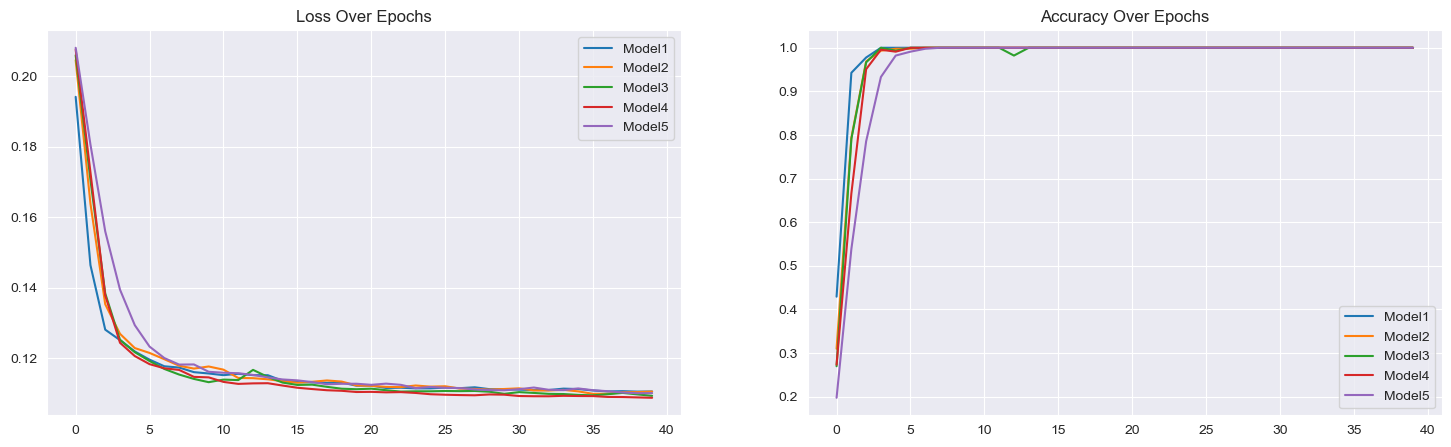

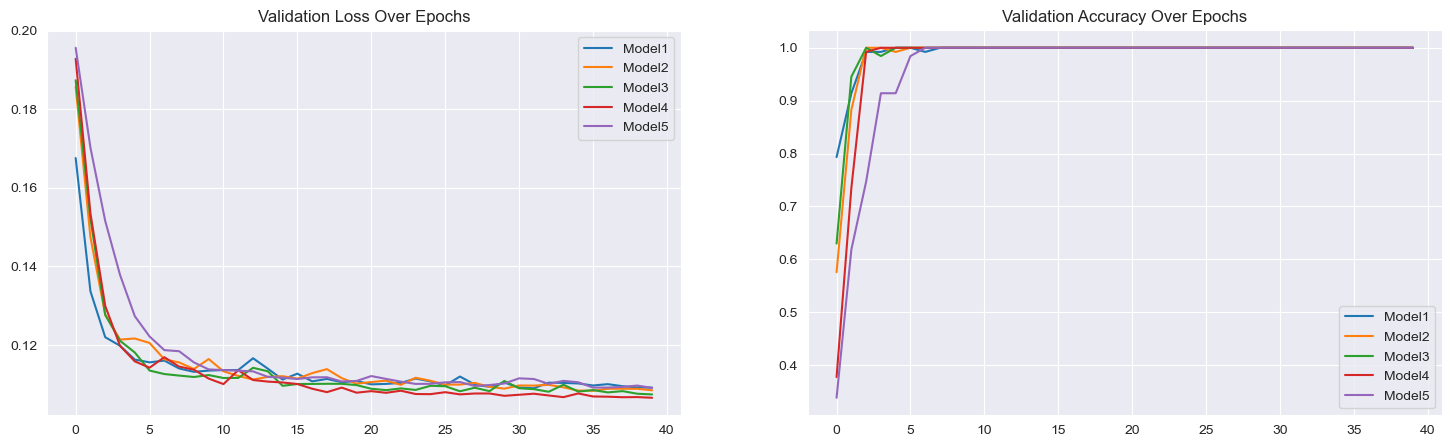

In [51]:
def test_model(hidden_layers_sizes):
    ann = ANNClassifier(input_shape=X_train.shape[1:], num_classes=y_train.shape[1],
                        hidden_layers_sizes=hidden_layers_sizes)
    ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003))
    gmm = GMMClassifier(n_components=y_train.shape[1])
    ensemble = Ensemble(ann, gmm)
    history = ensemble.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))
    y_pred = ensemble.predict(X_test)
    mapped_predictions = remap_labels(np.argmax(y_test, axis=1), y_pred)
    confusion_matrix(np.argmax(y_test, axis=1), mapped_predictions)
    accuracy = custom_accuracy(np.argmax(y_test, axis=1), mapped_predictions).numpy()
    return history, accuracy


Model1_history, Model1_accuracy = test_model((128, 128))
Model2_history, Model2_accuracy = test_model((128, 128, 128))
Model3_history, Model3_accuracy = test_model((128, 128, 128, 128))
Model4_history, Model4_accuracy = test_model((128, 128, 128, 128, 128))
Model5_history, Model5_accuracy = test_model((128, 64, 32, 32))

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(Model1_history.history['loss'], label='Model1')
plt.plot(Model2_history.history['loss'], label='Model2')
plt.plot(Model3_history.history['loss'], label='Model3')
plt.plot(Model4_history.history['loss'], label='Model4')
plt.plot(Model5_history.history['loss'], label='Model5')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Model1_history.history['accuracy'], label='Model1')
plt.plot(Model2_history.history['accuracy'], label='Model2')
plt.plot(Model3_history.history['accuracy'], label='Model3')
plt.plot(Model4_history.history['accuracy'], label='Model4')
plt.plot(Model5_history.history['accuracy'], label='Model5')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(Model1_history.history['val_loss'], label='Model1')
plt.plot(Model2_history.history['val_loss'], label='Model2')
plt.plot(Model3_history.history['val_loss'], label='Model3')
plt.plot(Model4_history.history['val_loss'], label='Model4')
plt.plot(Model5_history.history['val_loss'], label='Model5')
plt.title('Validation Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Model1_history.history['val_accuracy'], label='Model1')
plt.plot(Model2_history.history['val_accuracy'], label='Model2')
plt.plot(Model3_history.history['val_accuracy'], label='Model3')
plt.plot(Model4_history.history['val_accuracy'], label='Model4')
plt.plot(Model5_history.history['val_accuracy'], label='Model5')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

print("Validation loss of ANN in model1:", f"{Model1_history.history['val_loss'][-1]:.4f}")
print("Validation loss of ANN in model2:", f"{Model2_history.history['val_loss'][-1]:.4f}")
print("Validation loss of ANN in model3:", f"{Model3_history.history['val_loss'][-1]:.4f}")
print("Validation loss of ANN in model4:", f"{Model4_history.history['val_loss'][-1]:.4f}")
print("Validation loss of ANN in model5:", f"{Model5_history.history['val_loss'][-1]:.4f}")
print("Validation accuracy of ANN in Model1:", f"{Model1_history.history['val_accuracy'][-1]:.4f}")
print("Validation accuracy of ANN in Model2:", f"{Model2_history.history['val_accuracy'][-1]:.4f}")
print("Validation accuracy of ANN in Model3:", f"{Model3_history.history['val_accuracy'][-1]:.4f}")
print("Validation accuracy of ANN in Model4:", f"{Model4_history.history['val_accuracy'][-1]:.4f}")
print("Validation accuracy of ANN in Model5:", f"{Model5_history.history['val_accuracy'][-1]:.4f}")

## 7.2 Set different learning rates of ANN

Epoch 1/40


2023-12-14 11:16:33.779694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.2135 - accuracy: 0.1653

2023-12-14 11:16:35.399604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 2s 100ms/step - loss: 0.2135 - accuracy: 0.1653 - val_loss: 0.2076 - val_accuracy: 0.2410
Epoch 2/40
14/14 [==============================] - 0s 27ms/step - loss: 0.2057 - accuracy: 0.3470 - val_loss: 0.1994 - val_accuracy: 0.5252
Epoch 3/40
14/14 [==============================] - 0s 21ms/step - loss: 0.1938 - accuracy: 0.5875 - val_loss: 0.1867 - val_accuracy: 0.6112
Epoch 4/40
14/14 [==============================] - 0s 20ms/step - loss: 0.1766 - accuracy: 0.7551 - val_loss: 0.1707 - val_accuracy: 0.6496
Epoch 5/40
14/14 [==============================] - 0s 22ms/step - loss: 0.1585 - accuracy: 0.8712 - val_loss: 0.1549 - val_accuracy: 0.8672
Epoch 6/40
14/14 [==============================] - 0s 21ms/step - loss: 0.1420 - accuracy: 0.9360 - val_loss: 0.1403 - val_accuracy: 0.8828
Epoch 7/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1307 - accuracy: 0.9732 - val_loss: 0.1305 - val_accuracy: 0.9531
Epoch 8/40
14/14 [=====

2023-12-14 11:16:44.930042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 12ms/step
(435, 32)
4/4 [==============================] - 0s 27ms/step


Classify Report of Ensemble Model
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       0.00       0.00       0.00       0.50          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.0

2023-12-14 11:16:45.841818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.2104 - accuracy: 0.2565

2023-12-14 11:16:47.447842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 2s 97ms/step - loss: 0.2104 - accuracy: 0.2565 - val_loss: 0.1981 - val_accuracy: 0.5138
Epoch 2/40
14/14 [==============================] - 0s 33ms/step - loss: 0.1844 - accuracy: 0.6316 - val_loss: 0.1691 - val_accuracy: 0.7230
Epoch 3/40
14/14 [==============================] - 0s 21ms/step - loss: 0.1505 - accuracy: 0.8846 - val_loss: 0.1377 - val_accuracy: 0.8636
Epoch 4/40
14/14 [==============================] - 0s 22ms/step - loss: 0.1293 - accuracy: 0.9561 - val_loss: 0.1269 - val_accuracy: 0.9922
Epoch 5/40
14/14 [==============================] - 0s 20ms/step - loss: 0.1224 - accuracy: 0.9888 - val_loss: 0.1156 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1189 - accuracy: 1.0000 - val_loss: 0.1150 - val_accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1197 - accuracy: 0.9955 - val_loss: 0.1183 - val_accuracy: 1.0000
Epoch 8/40
14/14 [======

2023-12-14 11:16:57.351967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 11ms/step
(435, 32)
4/4 [==============================] - 0s 25ms/step


Classify Report of Ensemble Model
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.0

2023-12-14 11:16:58.471120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.2018 - accuracy: 0.3940

2023-12-14 11:17:00.201867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 2s 106ms/step - loss: 0.2018 - accuracy: 0.3940 - val_loss: 0.1766 - val_accuracy: 0.7037
Epoch 2/40
14/14 [==============================] - 0s 30ms/step - loss: 0.1542 - accuracy: 0.8467 - val_loss: 0.1395 - val_accuracy: 0.8906
Epoch 3/40
14/14 [==============================] - 0s 21ms/step - loss: 0.1305 - accuracy: 0.9538 - val_loss: 0.1316 - val_accuracy: 0.9183
Epoch 4/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1233 - accuracy: 0.9844 - val_loss: 0.1251 - val_accuracy: 0.9844
Epoch 5/40
14/14 [==============================] - 0s 22ms/step - loss: 0.1214 - accuracy: 0.9821 - val_loss: 0.1166 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1179 - accuracy: 1.0000 - val_loss: 0.1146 - val_accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1162 - accuracy: 1.0000 - val_loss: 0.1157 - val_accuracy: 1.0000
Epoch 8/40
14/14 [=====

2023-12-14 11:17:10.087554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 14ms/step
(435, 32)
4/4 [==============================] - 0s 47ms/step
Classify Report of Ensemble Model
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00    

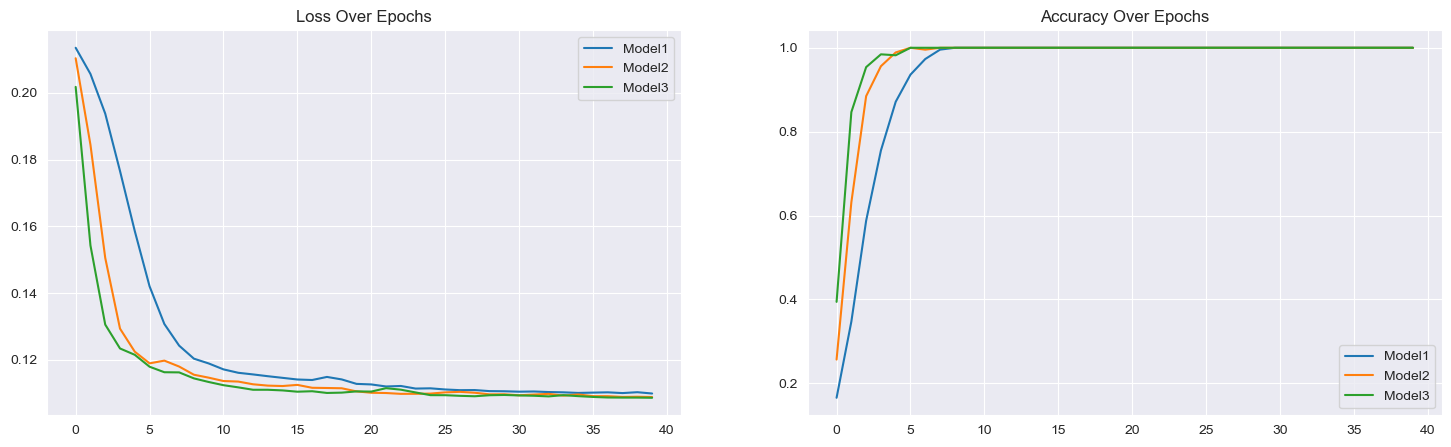

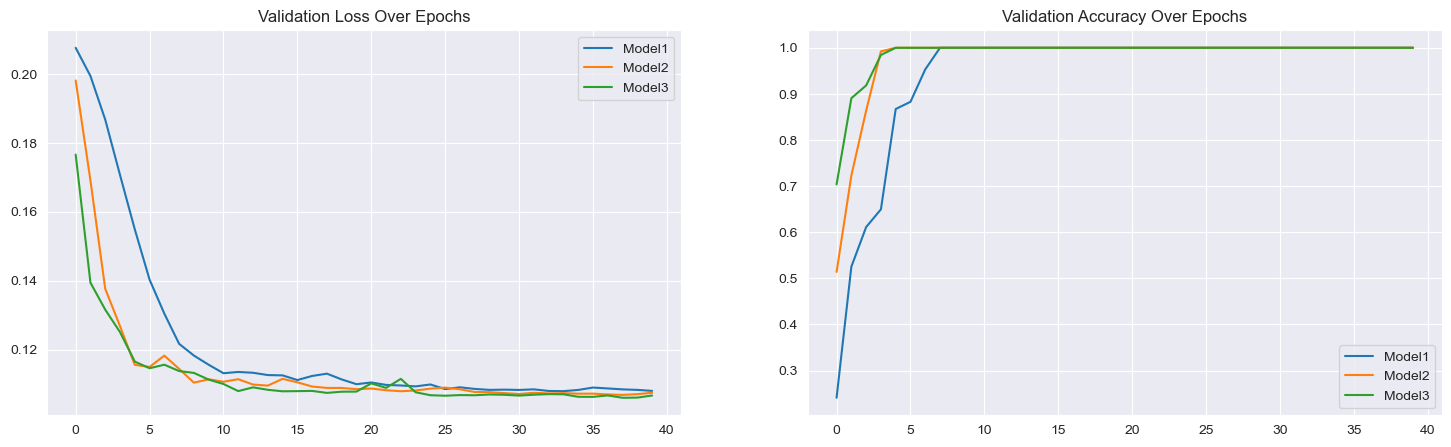

Validation loss of ANN in model1: 0.1081
Validation loss of ANN in model2: 0.1075
Validation loss of ANN in model3: 0.1067
Validation accuracy of ANN in Model1: 1.0000
Validation accuracy of ANN in Model2: 1.0000
Validation accuracy of ANN in Model3: 1.0000


In [55]:
def test_model(learning_rate):
    ann = ANNClassifier(input_shape=X_train.shape[1:], num_classes=y_train.shape[1],
                        hidden_layers_sizes=(128, 128, 128, 128, 128))
    ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    gmm = GMMClassifier(n_components=y_train.shape[1])
    ensemble = Ensemble(ann, gmm)
    history = ensemble.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))
    y_pred = ensemble.predict(X_test)
    mapped_predictions = remap_labels(np.argmax(y_test, axis=1), y_pred)
    confusion_matrix(np.argmax(y_test, axis=1), mapped_predictions)
    accuracy = custom_accuracy(np.argmax(y_test, axis=1), mapped_predictions).numpy()
    return history, accuracy


Model1_history, Model1_accuracy = test_model(0.0001)
Model2_history, Model2_accuracy = test_model(0.0003)
Model3_history, Model3_accuracy = test_model(0.0005)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(Model1_history.history['loss'], label='Model1')
plt.plot(Model2_history.history['loss'], label='Model2')
plt.plot(Model3_history.history['loss'], label='Model3')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Model1_history.history['accuracy'], label='Model1')
plt.plot(Model2_history.history['accuracy'], label='Model2')
plt.plot(Model3_history.history['accuracy'], label='Model3')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(Model1_history.history['val_loss'], label='Model1')
plt.plot(Model2_history.history['val_loss'], label='Model2')
plt.plot(Model3_history.history['val_loss'], label='Model3')
plt.title('Validation Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Model1_history.history['val_accuracy'], label='Model1')
plt.plot(Model2_history.history['val_accuracy'], label='Model2')
plt.plot(Model3_history.history['val_accuracy'], label='Model3')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.show()
print("Validation loss of ANN in model1:", f"{Model1_history.history['val_loss'][-1]:.4f}")
print("Validation loss of ANN in model2:", f"{Model2_history.history['val_loss'][-1]:.4f}")
print("Validation loss of ANN in model3:", f"{Model3_history.history['val_loss'][-1]:.4f}")
print("Validation accuracy of ANN in Model1:", f"{Model1_history.history['val_accuracy'][-1]:.4f}")
print("Validation accuracy of ANN in Model2:", f"{Model2_history.history['val_accuracy'][-1]:.4f}")
print("Validation accuracy of ANN in Model3:", f"{Model3_history.history['val_accuracy'][-1]:.4f}")

## 7.3 Set different batch sizes of ANN

Epoch 1/40


2023-12-14 10:55:00.311500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - ETA: 0s - loss: 0.1783 - accuracy: 0.4241

2023-12-14 10:55:01.699208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 2s 43ms/step - loss: 0.1783 - accuracy: 0.4241 - val_loss: 0.1597 - val_accuracy: 0.7012
Epoch 2/40
28/28 [==============================] - 0s 18ms/step - loss: 0.1301 - accuracy: 0.8504 - val_loss: 0.1233 - val_accuracy: 0.8661
Epoch 3/40
28/28 [==============================] - 0s 18ms/step - loss: 0.1091 - accuracy: 0.9799 - val_loss: 0.1036 - val_accuracy: 1.0000
Epoch 4/40
28/28 [==============================] - 0s 15ms/step - loss: 0.1013 - accuracy: 0.9978 - val_loss: 0.1050 - val_accuracy: 0.9821
Epoch 5/40
28/28 [==============================] - 0s 17ms/step - loss: 0.1011 - accuracy: 0.9978 - val_loss: 0.0994 - val_accuracy: 1.0000
Epoch 6/40
28/28 [==============================] - 0s 16ms/step - loss: 0.0971 - accuracy: 1.0000 - val_loss: 0.0981 - val_accuracy: 0.9911
Epoch 7/40
28/28 [==============================] - 0s 16ms/step - loss: 0.0970 - accuracy: 1.0000 - val_loss: 0.1039 - val_accuracy: 0.9911
Epoch 8/40
28/28 [======

2023-12-14 10:55:18.348676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 44ms/step


Classify Report of Ensemble Model
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       0.71       1.00       0.83       0.99          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       0.82       0.90       0.91         11
        14       1.00       1.00       1.0

2023-12-14 10:55:19.261859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.2070 - accuracy: 0.3092

2023-12-14 10:55:20.443458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 2s 78ms/step - loss: 0.2070 - accuracy: 0.3092 - val_loss: 0.1924 - val_accuracy: 0.5793
Epoch 2/40
14/14 [==============================] - 0s 29ms/step - loss: 0.1737 - accuracy: 0.7081 - val_loss: 0.1614 - val_accuracy: 0.7001
Epoch 3/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1395 - accuracy: 0.9449 - val_loss: 0.1358 - val_accuracy: 0.8558
Epoch 4/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1276 - accuracy: 0.9844 - val_loss: 0.1203 - val_accuracy: 1.0000
Epoch 5/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1233 - accuracy: 1.0000 - val_loss: 0.1204 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1195 - accuracy: 1.0000 - val_loss: 0.1154 - val_accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1175 - accuracy: 1.0000 - val_loss: 0.1156 - val_accuracy: 1.0000
Epoch 8/40
14/14 [======

2023-12-14 10:55:29.700302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 11ms/step
(435, 32)
4/4 [==============================] - 0s 32ms/step


Classify Report of Ensemble Model
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.0

2023-12-14 10:55:30.500269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - ETA: 0s - loss: 0.2338 - accuracy: 0.1262

2023-12-14 10:55:31.776299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 2s 156ms/step - loss: 0.2338 - accuracy: 0.1262 - val_loss: 0.2247 - val_accuracy: 0.4007
Epoch 2/40
7/7 [==============================] - 0s 43ms/step - loss: 0.2186 - accuracy: 0.5701 - val_loss: 0.2085 - val_accuracy: 0.6257
Epoch 3/40
7/7 [==============================] - 0s 34ms/step - loss: 0.1980 - accuracy: 0.7421 - val_loss: 0.1909 - val_accuracy: 0.7672
Epoch 4/40
7/7 [==============================] - 0s 33ms/step - loss: 0.1772 - accuracy: 0.9101 - val_loss: 0.1727 - val_accuracy: 0.8240
Epoch 5/40
7/7 [==============================] - 0s 24ms/step - loss: 0.1606 - accuracy: 0.9369 - val_loss: 0.1612 - val_accuracy: 0.8729
Epoch 6/40
7/7 [==============================] - 0s 23ms/step - loss: 0.1498 - accuracy: 0.9838 - val_loss: 0.1453 - val_accuracy: 0.9342
Epoch 7/40
7/7 [==============================] - 0s 22ms/step - loss: 0.1443 - accuracy: 0.9950 - val_loss: 0.1429 - val_accuracy: 0.9576
Epoch 8/40
7/7 [=====================

2023-12-14 10:55:39.445448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 2s 11ms/step
(435, 32)
4/4 [==============================] - 0s 25ms/step
Classify Report of Ensemble Model
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       0.83       1.00       0.91       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       0.86       0.92       0.93          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00    

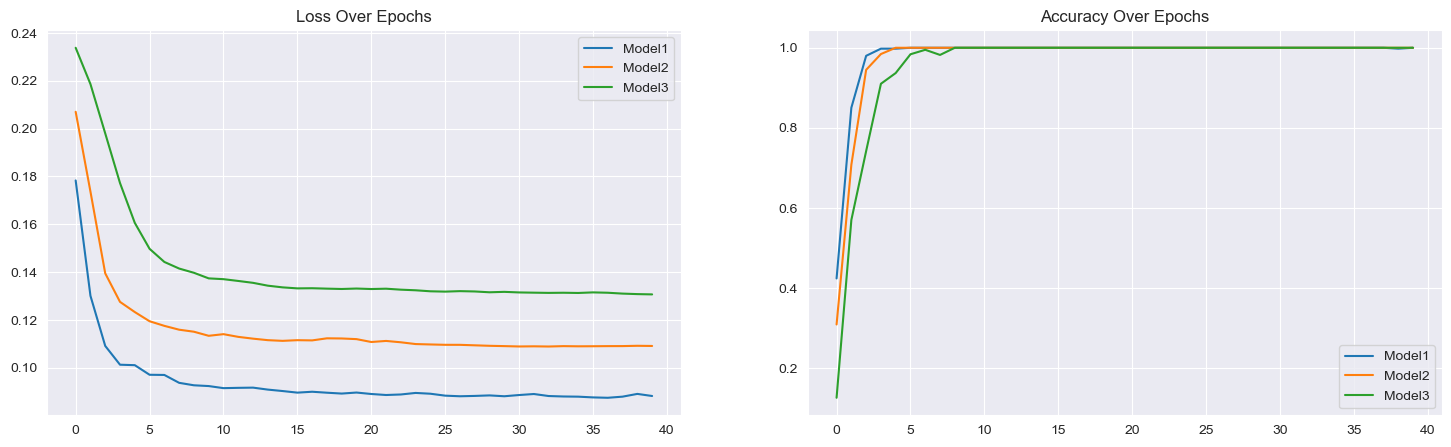

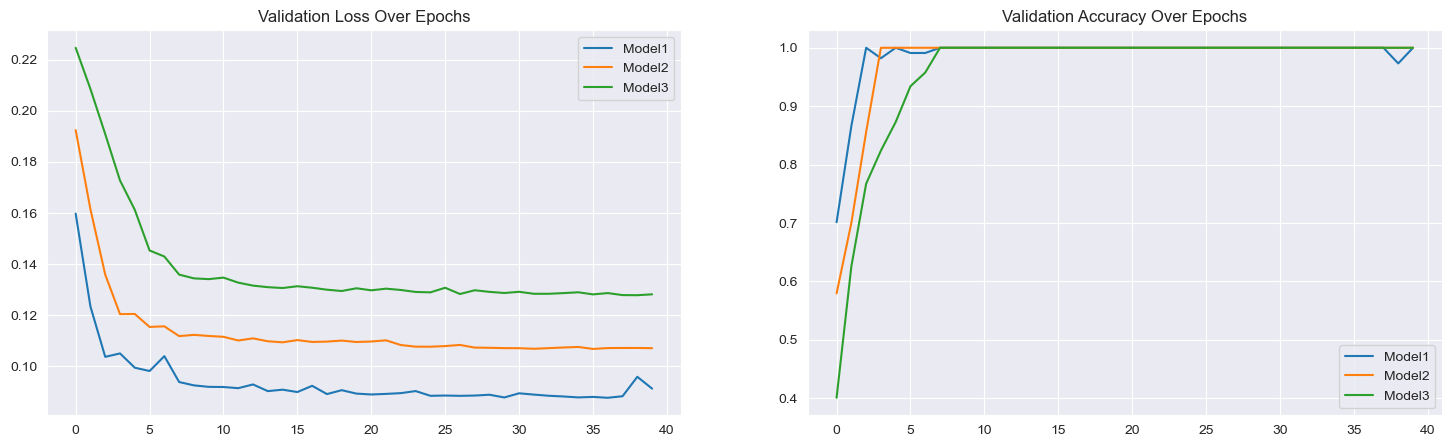

Validation loss of ANN in model1: 0.0912
Validation loss of ANN in model2: 0.1070
Validation loss of ANN in model3: 0.1281
Validation accuracy of ANN in Model1: 1.0000
Validation accuracy of ANN in Model2: 1.0000
Validation accuracy of ANN in Model3: 1.0000


In [48]:
def test_model(batch_size):
    ann = ANNClassifier(input_shape=X_train.shape[1:], num_classes=y_train.shape[1],
                        hidden_layers_sizes=(128, 128, 128, 128, 128))
    ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003))
    gmm = GMMClassifier(n_components=y_train.shape[1])
    ensemble = Ensemble(ann, gmm)
    history = ensemble.fit(X_train, y_train, epochs=40, batch_size=batch_size, validation_data=(X_test, y_test))
    y_pred = ensemble.predict(X_test)
    mapped_predictions = remap_labels(np.argmax(y_test, axis=1), y_pred)
    confusion_matrix(np.argmax(y_test, axis=1), mapped_predictions)
    accuracy = custom_accuracy(np.argmax(y_test, axis=1), mapped_predictions).numpy()
    return history, accuracy


Model1_history, Model1_accuracy = test_model(16)
Model2_history, Model2_accuracy = test_model(32)
Model3_history, Model3_accuracy = test_model(64)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(Model1_history.history['loss'], label='Model1')
plt.plot(Model2_history.history['loss'], label='Model2')
plt.plot(Model3_history.history['loss'], label='Model3')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Model1_history.history['accuracy'], label='Model1')
plt.plot(Model2_history.history['accuracy'], label='Model2')
plt.plot(Model3_history.history['accuracy'], label='Model3')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(Model1_history.history['val_loss'], label='Model1')
plt.plot(Model2_history.history['val_loss'], label='Model2')
plt.plot(Model3_history.history['val_loss'], label='Model3')
plt.title('Validation Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Model1_history.history['val_accuracy'], label='Model1')
plt.plot(Model2_history.history['val_accuracy'], label='Model2')
plt.plot(Model3_history.history['val_accuracy'], label='Model3')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.show()
print("Validation loss of ANN in model1:", f"{Model1_history.history['val_loss'][-1]:.4f}")
print("Validation loss of ANN in model2:", f"{Model2_history.history['val_loss'][-1]:.4f}")
print("Validation loss of ANN in model3:", f"{Model3_history.history['val_loss'][-1]:.4f}")
print("Validation accuracy of ANN in Model1:", f"{Model1_history.history['val_accuracy'][-1]:.4f}")
print("Validation accuracy of ANN in Model2:", f"{Model2_history.history['val_accuracy'][-1]:.4f}")
print("Validation accuracy of ANN in Model3:", f"{Model3_history.history['val_accuracy'][-1]:.4f}")

## 7.4 Set different optimizers of ANN

Epoch 1/40


2023-12-14 10:45:03.312182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.2023 - accuracy: 0.3114

2023-12-14 10:45:04.410925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 64ms/step - loss: 0.2023 - accuracy: 0.3114 - val_loss: 0.1859 - val_accuracy: 0.5992
Epoch 2/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1629 - accuracy: 0.8407 - val_loss: 0.1483 - val_accuracy: 0.8714
Epoch 3/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1332 - accuracy: 0.9844 - val_loss: 0.1253 - val_accuracy: 1.0000
Epoch 4/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1230 - accuracy: 1.0000 - val_loss: 0.1184 - val_accuracy: 1.0000
Epoch 5/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1211 - accuracy: 1.0000 - val_loss: 0.1213 - val_accuracy: 0.9922
Epoch 6/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1205 - accuracy: 0.9978 - val_loss: 0.1143 - val_accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1173 - accuracy: 1.0000 - val_loss: 0.1134 - val_accuracy: 1.0000
Epoch 8/40
14/14 [======

2023-12-14 10:45:13.183174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 19ms/step


Classify Report of Ensemble Model
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.0

2023-12-14 10:45:13.926860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 56ms/step - loss: 0.2157 - accuracy: 0.0134 - val_loss: 0.2142 - val_accuracy: 0.0312
Epoch 2/40


2023-12-14 10:45:14.779328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 20ms/step - loss: 0.2157 - accuracy: 0.0149 - val_loss: 0.2142 - val_accuracy: 0.0312
Epoch 3/40
14/14 [==============================] - 0s 16ms/step - loss: 0.2157 - accuracy: 0.0134 - val_loss: 0.2142 - val_accuracy: 0.0312
Epoch 4/40
14/14 [==============================] - 0s 18ms/step - loss: 0.2157 - accuracy: 0.0134 - val_loss: 0.2142 - val_accuracy: 0.0312
Epoch 5/40
14/14 [==============================] - 0s 16ms/step - loss: 0.2157 - accuracy: 0.0134 - val_loss: 0.2142 - val_accuracy: 0.0312
Epoch 6/40
14/14 [==============================] - 0s 15ms/step - loss: 0.2157 - accuracy: 0.0134 - val_loss: 0.2142 - val_accuracy: 0.0312
Epoch 7/40
14/14 [==============================] - 0s 16ms/step - loss: 0.2157 - accuracy: 0.0134 - val_loss: 0.2142 - val_accuracy: 0.0312
Epoch 8/40
14/14 [==============================] - 0s 14ms/step - loss: 0.2157 - accuracy: 0.0134 - val_loss: 0.2142 - val_accuracy: 0.0312
Epoch 9/40
14/14 [======

2023-12-14 10:45:23.179936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 9ms/step
(435, 32)
4/4 [==============================] - 0s 52ms/step


Classify Report of Ensemble Model
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       0.00       0.00       0.00       0.50          5
         2       0.00       0.00       0.00       0.50          2
         3       0.00       0.00       0.00       0.50          2
         4       0.00       0.00       0.00       0.50          5
         5       0.00       0.00       0.00       0.50          1
         6       0.00       0.00       0.00       0.50          3
         7       0.00       0.00       0.00       0.50          2
         8       0.00       0.00       0.00       0.50          4
         9       0.00       0.00       0.00       0.50          7
        10       0.00       0.00       0.00       0.50          3
        11       0.00       0.00       0.00       0.50          4
        12       0.00       0.00       0.00       0.50          2
        13       0.00       0.00       0.00       0.50         11
        14       0.00       0.00       0.0

Epoch 1/40


2023-12-14 10:45:24.124576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 2s 78ms/step - loss: 0.1922 - accuracy: 0.4209 - val_loss: 0.1652 - val_accuracy: 0.7620
Epoch 2/40


2023-12-14 10:45:25.568737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 29ms/step - loss: 0.1511 - accuracy: 0.8884 - val_loss: 0.1388 - val_accuracy: 0.8714
Epoch 3/40
14/14 [==============================] - 0s 20ms/step - loss: 0.1325 - accuracy: 0.9672 - val_loss: 0.1389 - val_accuracy: 0.8906
Epoch 4/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1267 - accuracy: 0.9918 - val_loss: 0.1217 - val_accuracy: 1.0000
Epoch 5/40
14/14 [==============================] - 0s 21ms/step - loss: 0.1229 - accuracy: 0.9955 - val_loss: 0.1206 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 21ms/step - loss: 0.1240 - accuracy: 0.9978 - val_loss: 0.1206 - val_accuracy: 0.9573
Epoch 7/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1202 - accuracy: 0.9911 - val_loss: 0.1172 - val_accuracy: 1.0000
Epoch 8/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1197 - accuracy: 1.0000 - val_loss: 0.1148 - val_accuracy: 1.0000
Epoch 9/40
14/14 [======

2023-12-14 10:45:35.719322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 17ms/step


Classify Report of Ensemble Model
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       0.83       1.00       0.91       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       0.00       0.00       0.00       0.50          4
         9       0.00       0.00       0.00       0.50          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.0

2023-12-14 10:45:36.377218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 61ms/step - loss: 0.2165 - accuracy: 0.0424 - val_loss: 0.2132 - val_accuracy: 0.0859


2023-12-14 10:45:37.279533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 2/40
14/14 [==============================] - 0s 19ms/step - loss: 0.2165 - accuracy: 0.0424 - val_loss: 0.2132 - val_accuracy: 0.0859
Epoch 3/40
14/14 [==============================] - 0s 19ms/step - loss: 0.2165 - accuracy: 0.0439 - val_loss: 0.2132 - val_accuracy: 0.0859
Epoch 4/40
14/14 [==============================] - 0s 17ms/step - loss: 0.2165 - accuracy: 0.0424 - val_loss: 0.2132 - val_accuracy: 0.0859
Epoch 5/40
14/14 [==============================] - 0s 17ms/step - loss: 0.2165 - accuracy: 0.0424 - val_loss: 0.2132 - val_accuracy: 0.0859
Epoch 6/40
14/14 [==============================] - 0s 16ms/step - loss: 0.2164 - accuracy: 0.0439 - val_loss: 0.2132 - val_accuracy: 0.0859
Epoch 7/40
14/14 [==============================] - 0s 15ms/step - loss: 0.2164 - accuracy: 0.0439 - val_loss: 0.2131 - val_accuracy: 0.0859
Epoch 8/40
14/14 [==============================] - 0s 17ms/step - loss: 0.2164 - accuracy: 0.0446 - val_loss: 0.2131 - val_accuracy: 0.0859
Epoch 9/40
14

2023-12-14 10:45:45.788643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 39ms/step
Classify Report of Ensemble Model
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       0.00       0.00       0.00       0.50          5
         2       0.00       0.00       0.00       0.50          2
         3       0.00       0.00       0.00       0.50          2
         4       0.00       0.00       0.00       0.50          5
         5       0.00       0.00       0.00       0.50          1
         6       0.00       0.00       0.00       0.50          3
         7       0.00       0.00       0.00       0.50          2
         8       0.00       0.00       0.00       0.50          4
         9       0.00       0.00       0.00       0.50          7
        10       0.00       0.00       0.00       0.50          3
        11       0.00       0.00       0.00       0.50          4
        12       0.00       0.00       0.00       0.50          2
        13       0.00       0.00       0.00       0.50  

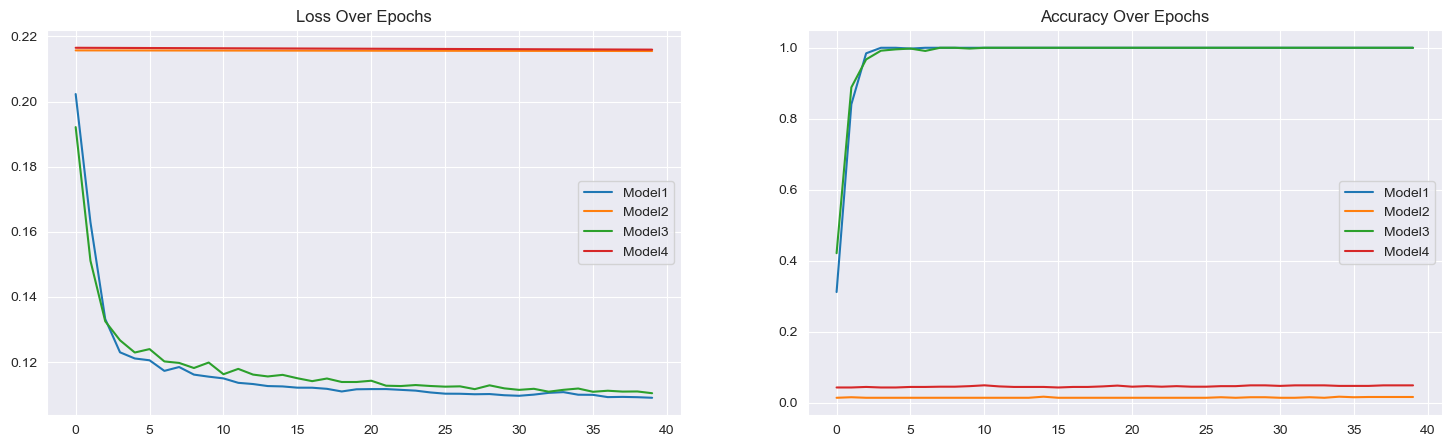

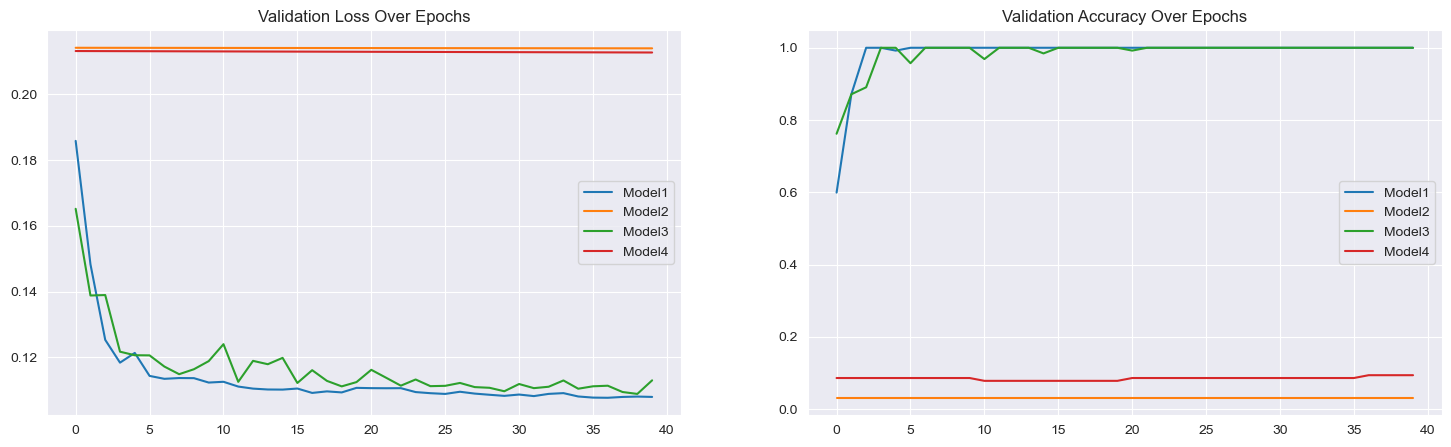

Validation loss of ANN in model1: 0.1079
Validation loss of ANN in model2: 0.2140
Validation loss of ANN in model3: 0.1130
Validation loss of ANN in model4: 0.2128
Validation accuracy of ANN in Model1: 1.0000
Validation accuracy of ANN in Model2: 0.0312
Validation accuracy of ANN in Model3: 1.0000
Validation accuracy of ANN in Model4: 0.0938


In [46]:
def test_model(optimizer):
    ann = ANNClassifier(input_shape=X_train.shape[1:], num_classes=y_train.shape[1],
                        hidden_layers_sizes=(128, 128, 128, 128))
    ann.compile(optimizer=optimizer)
    gmm = GMMClassifier(n_components=y_train.shape[1])
    ensemble = Ensemble(ann, gmm)
    history = ensemble.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))
    y_pred = ensemble.predict(X_test)
    mapped_predictions = remap_labels(np.argmax(y_test, axis=1), y_pred)
    confusion_matrix(np.argmax(y_test, axis=1), mapped_predictions)
    accuracy = custom_accuracy(np.argmax(y_test, axis=1), mapped_predictions).numpy()
    return history, accuracy


Model1_history, Model1_accuracy = test_model(tf.keras.optimizers.Adam(learning_rate=0.0003))
Model2_history, Model2_accuracy = test_model(tf.keras.optimizers.SGD(learning_rate=0.0003))
Model3_history, Model3_accuracy = test_model(tf.keras.optimizers.RMSprop(learning_rate=0.0003))
Model4_history, Model4_accuracy = test_model(tf.keras.optimizers.Adagrad(learning_rate=0.0003))

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(Model1_history.history['loss'], label='Model1')
plt.plot(Model2_history.history['loss'], label='Model2')
plt.plot(Model3_history.history['loss'], label='Model3')
plt.plot(Model4_history.history['loss'], label='Model4')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Model1_history.history['accuracy'], label='Model1')
plt.plot(Model2_history.history['accuracy'], label='Model2')
plt.plot(Model3_history.history['accuracy'], label='Model3')
plt.plot(Model4_history.history['accuracy'], label='Model4')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(Model1_history.history['val_loss'], label='Model1')
plt.plot(Model2_history.history['val_loss'], label='Model2')
plt.plot(Model3_history.history['val_loss'], label='Model3')
plt.plot(Model4_history.history['val_loss'], label='Model4')
plt.title('Validation Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Model1_history.history['val_accuracy'], label='Model1')
plt.plot(Model2_history.history['val_accuracy'], label='Model2')
plt.plot(Model3_history.history['val_accuracy'], label='Model3')
plt.plot(Model4_history.history['val_accuracy'], label='Model4')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.show()
print("Validation loss of ANN in model1:", f"{Model1_history.history['val_loss'][-1]:.4f}")
print("Validation loss of ANN in model2:", f"{Model2_history.history['val_loss'][-1]:.4f}")
print("Validation loss of ANN in model3:", f"{Model3_history.history['val_loss'][-1]:.4f}")
print("Validation loss of ANN in model4:", f"{Model4_history.history['val_loss'][-1]:.4f}")
print("Validation accuracy of ANN in Model1:", f"{Model1_history.history['val_accuracy'][-1]:.4f}")
print("Validation accuracy of ANN in Model2:", f"{Model2_history.history['val_accuracy'][-1]:.4f}")
print("Validation accuracy of ANN in Model3:", f"{Model3_history.history['val_accuracy'][-1]:.4f}")
print("Validation accuracy of ANN in Model4:", f"{Model4_history.history['val_accuracy'][-1]:.4f}")

## 7.5 Set different epochs of ANN

Epoch 1/20


2023-12-14 11:11:13.643606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.1890 - accuracy: 0.4292

2023-12-14 11:11:15.140450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 2s 94ms/step - loss: 0.1890 - accuracy: 0.4292 - val_loss: 0.1529 - val_accuracy: 0.6887
Epoch 2/20
14/14 [==============================] - 0s 28ms/step - loss: 0.1366 - accuracy: 0.9308 - val_loss: 0.1407 - val_accuracy: 0.8365
Epoch 3/20
14/14 [==============================] - 0s 21ms/step - loss: 0.1396 - accuracy: 0.9241 - val_loss: 0.1283 - val_accuracy: 0.9303
Epoch 4/20
14/14 [==============================] - 0s 19ms/step - loss: 0.1248 - accuracy: 0.9888 - val_loss: 0.1201 - val_accuracy: 1.0000
Epoch 5/20
14/14 [==============================] - 0s 18ms/step - loss: 0.1172 - accuracy: 1.0000 - val_loss: 0.1154 - val_accuracy: 1.0000
Epoch 6/20
14/14 [==============================] - 0s 20ms/step - loss: 0.1157 - accuracy: 1.0000 - val_loss: 0.1146 - val_accuracy: 1.0000
Epoch 7/20
14/14 [==============================] - 0s 28ms/step - loss: 0.1202 - accuracy: 0.9844 - val_loss: 0.1203 - val_accuracy: 0.9922
Epoch 8/20
14/14 [======

2023-12-14 11:11:20.360960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 27ms/step


Classify Report of Ensemble Model
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       0.00       0.00       0.00       0.50         11
        14       1.00       1.00       1.0

2023-12-14 11:11:22.071358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.4665

2023-12-14 11:11:23.483471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 2s 87ms/step - loss: 0.1867 - accuracy: 0.4665 - val_loss: 0.1490 - val_accuracy: 0.8167
Epoch 2/40
14/14 [==============================] - 0s 28ms/step - loss: 0.1362 - accuracy: 0.9203 - val_loss: 0.1273 - val_accuracy: 0.9922
Epoch 3/40
14/14 [==============================] - 0s 31ms/step - loss: 0.1272 - accuracy: 0.9777 - val_loss: 0.1259 - val_accuracy: 0.9766
Epoch 4/40
14/14 [==============================] - 0s 27ms/step - loss: 0.1251 - accuracy: 0.9777 - val_loss: 0.1180 - val_accuracy: 1.0000
Epoch 5/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1208 - accuracy: 0.9978 - val_loss: 0.1177 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1214 - accuracy: 0.9925 - val_loss: 0.1223 - val_accuracy: 0.9531
Epoch 7/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1209 - accuracy: 0.9888 - val_loss: 0.1206 - val_accuracy: 0.9922
Epoch 8/40
14/14 [======

2023-12-14 11:11:32.686590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 10ms/step
(435, 32)
4/4 [==============================] - 0s 40ms/step


Classify Report of Ensemble Model
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.0

2023-12-14 11:11:33.563374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.1864 - accuracy: 0.4858

2023-12-14 11:11:35.096079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 2s 87ms/step - loss: 0.1864 - accuracy: 0.4858 - val_loss: 0.1500 - val_accuracy: 0.7236
Epoch 2/60
14/14 [==============================] - 0s 24ms/step - loss: 0.1336 - accuracy: 0.9270 - val_loss: 0.1259 - val_accuracy: 0.9730
Epoch 3/60
14/14 [==============================] - 0s 20ms/step - loss: 0.1311 - accuracy: 0.9799 - val_loss: 0.1238 - val_accuracy: 0.9922
Epoch 4/60
14/14 [==============================] - 0s 19ms/step - loss: 0.1229 - accuracy: 1.0000 - val_loss: 0.1182 - val_accuracy: 1.0000
Epoch 5/60
14/14 [==============================] - 0s 18ms/step - loss: 0.1188 - accuracy: 1.0000 - val_loss: 0.1150 - val_accuracy: 1.0000
Epoch 6/60
14/14 [==============================] - 0s 17ms/step - loss: 0.1172 - accuracy: 1.0000 - val_loss: 0.1149 - val_accuracy: 1.0000
Epoch 7/60
14/14 [==============================] - 0s 15ms/step - loss: 0.1175 - accuracy: 1.0000 - val_loss: 0.1141 - val_accuracy: 1.0000
Epoch 8/60
14/14 [======

2023-12-14 11:11:48.078555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 10ms/step
(435, 32)
4/4 [==============================] - 0s 24ms/step
Classify Report of Ensemble Model
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00    

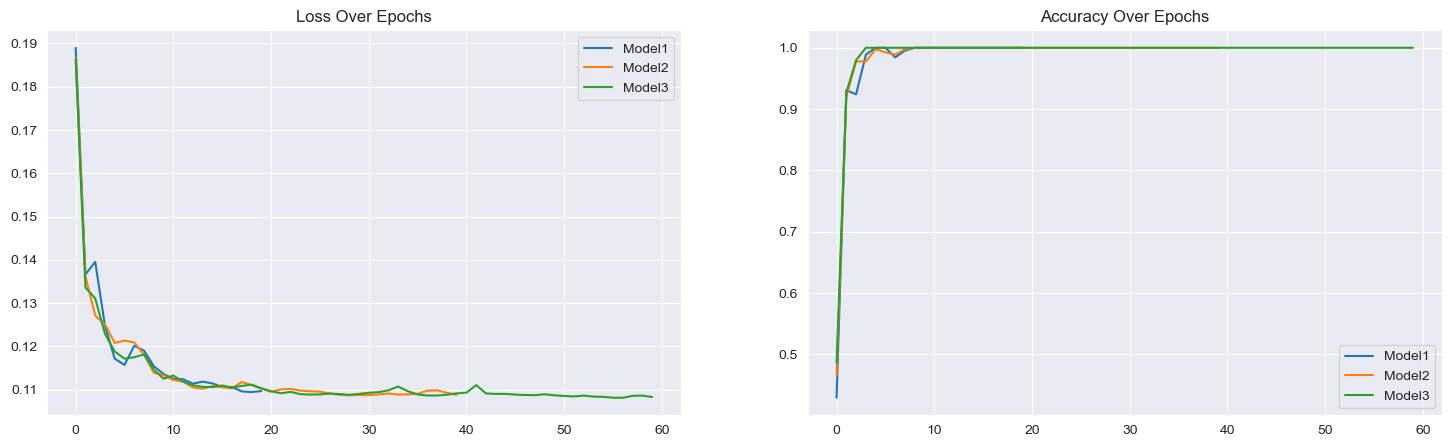

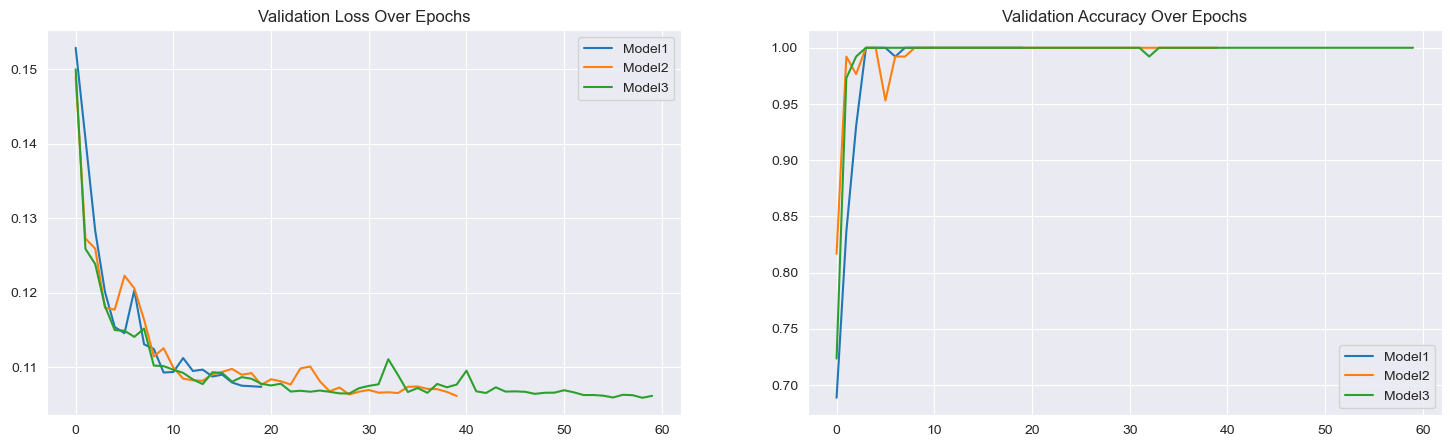

Validation loss of ANN in model1: 0.1073
Validation loss of ANN in model2: 0.1061
Validation loss of ANN in model3: 0.1061
Validation accuracy of ANN in Model1: 1.0000
Validation accuracy of ANN in Model2: 1.0000
Validation accuracy of ANN in Model3: 1.0000


In [53]:
def test_model(epochs):
    ann = ANNClassifier(input_shape=X_train.shape[1:], num_classes=y_train.shape[1],
                        hidden_layers_sizes=(128, 128, 128, 128))
    ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
    gmm = GMMClassifier(n_components=y_train.shape[1])
    ensemble = Ensemble(ann, gmm)
    history = ensemble.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test))
    y_pred = ensemble.predict(X_test)
    mapped_predictions = remap_labels(np.argmax(y_test, axis=1), y_pred)
    confusion_matrix(np.argmax(y_test, axis=1), mapped_predictions)
    accuracy = custom_accuracy(np.argmax(y_test, axis=1), mapped_predictions).numpy()
    return history, accuracy


Model1_history, Model1_accuracy = test_model(20)
Model2_history, Model2_accuracy = test_model(40)
Model3_history, Model3_accuracy = test_model(60)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(Model1_history.history['loss'], label='Model1')
plt.plot(Model2_history.history['loss'], label='Model2')
plt.plot(Model3_history.history['loss'], label='Model3')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Model1_history.history['accuracy'], label='Model1')
plt.plot(Model2_history.history['accuracy'], label='Model2')
plt.plot(Model3_history.history['accuracy'], label='Model3')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
plt.plot(Model1_history.history['val_loss'], label='Model1')
plt.plot(Model2_history.history['val_loss'], label='Model2')
plt.plot(Model3_history.history['val_loss'], label='Model3')
plt.title('Validation Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Model1_history.history['val_accuracy'], label='Model1')
plt.plot(Model2_history.history['val_accuracy'], label='Model2')
plt.plot(Model3_history.history['val_accuracy'], label='Model3')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.show()
print("Validation loss of ANN in model1:", f"{Model1_history.history['val_loss'][-1]:.4f}")
print("Validation loss of ANN in model2:", f"{Model2_history.history['val_loss'][-1]:.4f}")
print("Validation loss of ANN in model3:", f"{Model3_history.history['val_loss'][-1]:.4f}")
print("Validation accuracy of ANN in Model1:", f"{Model1_history.history['val_accuracy'][-1]:.4f}")
print("Validation accuracy of ANN in Model2:", f"{Model2_history.history['val_accuracy'][-1]:.4f}")
print("Validation accuracy of ANN in Model3:", f"{Model3_history.history['val_accuracy'][-1]:.4f}")

## 7.6 Set different number of components of GMM

In [32]:
def test_model(n_components):
    ann = ANNClassifier(input_shape=X_train.shape[1:], num_classes=y_train.shape[1],
                        hidden_layers_sizes=(128, 128, 128, 128, 128))
    ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003))
    gmm = GMMClassifier(n_components=n_components)
    ensemble = Ensemble(ann, gmm)
    history = ensemble.fit(X_train, y_train, epochs=40, batch_size=32, validation_data=(X_test, y_test))
    y_pred = ensemble.predict(X_test)
    mapped_predictions = remap_labels(np.argmax(y_test, axis=1), y_pred)
    confusion_matrix(np.argmax(y_test, axis=1), mapped_predictions)
    accuracy = custom_accuracy(np.argmax(y_test, axis=1), mapped_predictions).numpy()
    return history, accuracy


Model1_history, Model1_accuracy = test_model(2)
Model2_history, Model2_accuracy = test_model(8)
Model3_history, Model3_accuracy = test_model(16)
Model4_history, Model4_accuracy = test_model(y_train.shape[1])

print("Final loss of Model1:", f"{Model1_history.history['val_loss'][-1]:.4f}")
print("Final loss of Model2:", f"{Model2_history.history['val_loss'][-1]:.4f}")
print("Final loss of Model3:", f"{Model3_history.history['val_loss'][-1]:.4f}")
print("Final loss of Model4:", f"{Model4_history.history['val_loss'][-1]:.4f}")
print("Final accuracy of Model1:", f"{Model1_accuracy:.3f}%")
print("Final accuracy of Model2:", f"{Model2_accuracy:.3f}%")
print("Final accuracy of Model3:", f"{Model3_accuracy:.3f}%")
print("Final accuracy of Model4:", f"{Model4_accuracy:.3f}%")

Epoch 1/40


2023-12-14 10:33:21.853743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 56ms/step - loss: 0.2083 - accuracy: 0.2570 - val_loss: 0.1940 - val_accuracy: 0.5367
Epoch 2/40


2023-12-14 10:33:22.746188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 20ms/step - loss: 0.1768 - accuracy: 0.7835 - val_loss: 0.1632 - val_accuracy: 0.8245
Epoch 3/40
14/14 [==============================] - 0s 19ms/step - loss: 0.1424 - accuracy: 0.9628 - val_loss: 0.1365 - val_accuracy: 0.8870
Epoch 4/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1256 - accuracy: 0.9821 - val_loss: 0.1286 - val_accuracy: 0.9688
Epoch 5/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1271 - accuracy: 0.9799 - val_loss: 0.1237 - val_accuracy: 0.9922
Epoch 6/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1207 - accuracy: 1.0000 - val_loss: 0.1174 - val_accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1168 - accuracy: 1.0000 - val_loss: 0.1137 - val_accuracy: 1.0000
Epoch 8/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1155 - accuracy: 1.0000 - val_loss: 0.1131 - val_accuracy: 1.0000
Epoch 9/40
14/14 [======

2023-12-14 10:33:31.576207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 23ms/step
Classify Report of Ensemble Model
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       0.00       0.00       0.00       0.50          5
         2       0.00       0.00       0.00       0.50          2
         3       0.00       0.00       0.00       0.50          2
         4       0.00       0.00       0.00       0.50          5
         5       0.00       0.00       0.00       0.50          1
         6       0.00       0.00       0.00       0.50          3
         7       0.00       0.00       0.00       0.50          2
         8       0.00       0.00       0.00       0.50          4
         9       0.00       0.00       0.00       0.50          7
        10       0.00       0.00       0.00       0.50          3
        11       0.00       0.00       0.00       0.50          4
        12       0.67       1.00       0.80       1.00          2
        13       0.00       0.00       0.00   

Epoch 1/40


2023-12-14 10:33:32.221164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.2084 - accuracy: 0.2071

2023-12-14 10:33:33.140694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 59ms/step - loss: 0.2084 - accuracy: 0.2071 - val_loss: 0.1942 - val_accuracy: 0.4273
Epoch 2/40
14/14 [==============================] - 0s 22ms/step - loss: 0.1760 - accuracy: 0.6882 - val_loss: 0.1572 - val_accuracy: 0.8323
Epoch 3/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1400 - accuracy: 0.9487 - val_loss: 0.1315 - val_accuracy: 0.8401
Epoch 4/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1279 - accuracy: 0.9732 - val_loss: 0.1234 - val_accuracy: 1.0000
Epoch 5/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1256 - accuracy: 0.9844 - val_loss: 0.1216 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1210 - accuracy: 1.0000 - val_loss: 0.1152 - val_accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1170 - accuracy: 1.0000 - val_loss: 0.1132 - val_accuracy: 1.0000
Epoch 8/40
14/14 [======

2023-12-14 10:33:42.047201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 21ms/step
Classify Report of Ensemble Model
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       0.00       0.00       0.00       0.50          5
         2       0.00       0.00       0.00       0.50          2
         3       0.00       0.00       0.00       0.50          2
         4       0.00       0.00       0.00       0.50          5
         5       1.00       1.00       1.00       1.00          1
         6       0.00       0.00       0.00       0.50          3
         7       0.00       0.00       0.00       0.50          2
         8       0.00       0.00       0.00       0.50          4
         9       0.00       0.00       0.00       0.50          7
        10       0.00       0.00       0.00       0.50          3
        11       0.00       0.00       0.00       0.50          4
        12       0.00       0.00       0.00       0.50          2
        13       0.00       0.00       0.00   

Epoch 1/40


2023-12-14 10:33:42.642067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.2087 - accuracy: 0.2668

2023-12-14 10:33:43.608212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 62ms/step - loss: 0.2087 - accuracy: 0.2668 - val_loss: 0.1938 - val_accuracy: 0.5601
Epoch 2/40
14/14 [==============================] - 0s 21ms/step - loss: 0.1751 - accuracy: 0.7543 - val_loss: 0.1598 - val_accuracy: 0.7740
Epoch 3/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1388 - accuracy: 0.9315 - val_loss: 0.1341 - val_accuracy: 0.8480
Epoch 4/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1267 - accuracy: 0.9695 - val_loss: 0.1234 - val_accuracy: 0.9922
Epoch 5/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1233 - accuracy: 0.9978 - val_loss: 0.1180 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 16ms/step - loss: 0.1197 - accuracy: 1.0000 - val_loss: 0.1154 - val_accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1190 - accuracy: 1.0000 - val_loss: 0.1181 - val_accuracy: 1.0000
Epoch 8/40
14/14 [======

2023-12-14 10:33:52.382529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 22ms/step


Classify Report of Ensemble Model
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       0.00       0.00       0.00       0.50          5
         2       0.67       1.00       0.80       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       0.00       0.00       0.00       0.50          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       0.00       0.00       0.00       0.50          4
         9       0.00       0.00       0.00       0.50          7
        10       1.00       1.00       1.00       1.00          3
        11       0.00       0.00       0.00       0.50          4
        12       0.00       0.00       0.00       0.50          2
        13       0.00       0.00       0.00       0.50         11
        14       1.00       1.00       1.0

2023-12-14 10:33:53.067940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.2986

2023-12-14 10:33:54.071589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 63ms/step - loss: 0.2077 - accuracy: 0.2986 - val_loss: 0.1937 - val_accuracy: 0.4087
Epoch 2/40
14/14 [==============================] - 0s 23ms/step - loss: 0.1749 - accuracy: 0.6383 - val_loss: 0.1574 - val_accuracy: 0.7434
Epoch 3/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1401 - accuracy: 0.9203 - val_loss: 0.1308 - val_accuracy: 0.9339
Epoch 4/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1259 - accuracy: 0.9866 - val_loss: 0.1195 - val_accuracy: 1.0000
Epoch 5/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1215 - accuracy: 0.9799 - val_loss: 0.1179 - val_accuracy: 1.0000
Epoch 6/40
14/14 [==============================] - 0s 17ms/step - loss: 0.1198 - accuracy: 1.0000 - val_loss: 0.1146 - val_accuracy: 1.0000
Epoch 7/40
14/14 [==============================] - 0s 18ms/step - loss: 0.1158 - accuracy: 1.0000 - val_loss: 0.1126 - val_accuracy: 1.0000
Epoch 8/40
14/14 [======

2023-12-14 10:34:03.408140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


(435, 32)
4/4 [==============================] - 0s 19ms/step
Classify Report of Ensemble Model
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00   

# 8. Final Model
In the final model, the ANN model has 4 hidden layers with 128 neurons per hidden layer, the learning rate of the optimizer is 0.001, the batch size is 32, and the number of epochs is 40.

In [39]:
image_paths = glob.glob('Car_Logo_Dataset/**/*.png', recursive=True)
X, y = load_images(image_paths, target_size=(32, 32))

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
ann = ANNClassifier(input_shape=X_train.shape[1:], num_classes=y_train.shape[1],
                    hidden_layers_sizes=(128, 128, 128, 128, 128))
ann.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003))
gmm = GMMClassifier(n_components=y_train.shape[1])
ensemble = Ensemble(ann, gmm)

In [22]:
history = ensemble.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))
y_pred = ensemble.predict(X_test)
y_test = np.argmax(y_test, axis=1)

Epoch 1/20


2023-12-14 13:04:44.692260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 36ms/step - loss: 0.2077 - accuracy: 0.2749 - val_loss: 0.1957 - val_accuracy: 0.5210
Epoch 2/20
 1/14 [=>............................] - ETA: 0s - loss: 0.1909 - accuracy: 0.7188

2023-12-14 13:04:45.294490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 16ms/step - loss: 0.1739 - accuracy: 0.7520 - val_loss: 0.1646 - val_accuracy: 0.6418
Epoch 3/20
14/14 [==============================] - 0s 17ms/step - loss: 0.1428 - accuracy: 0.9263 - val_loss: 0.1387 - val_accuracy: 0.8906
Epoch 4/20
14/14 [==============================] - 0s 16ms/step - loss: 0.1274 - accuracy: 0.9911 - val_loss: 0.1259 - val_accuracy: 1.0000
Epoch 5/20
14/14 [==============================] - 0s 16ms/step - loss: 0.1235 - accuracy: 0.9955 - val_loss: 0.1238 - val_accuracy: 1.0000
Epoch 6/20
14/14 [==============================] - 0s 16ms/step - loss: 0.1220 - accuracy: 1.0000 - val_loss: 0.1174 - val_accuracy: 1.0000
Epoch 7/20
14/14 [==============================] - 0s 18ms/step - loss: 0.1192 - accuracy: 1.0000 - val_loss: 0.1155 - val_accuracy: 1.0000
Epoch 8/20
14/14 [==============================] - 0s 18ms/step - loss: 0.1180 - accuracy: 1.0000 - val_loss: 0.1141 - val_accuracy: 1.0000
Epoch 9/20
14/14 [======

2023-12-14 13:04:49.811204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 13ms/step


In [25]:
mapped_predictions = remap_labels(y_test, y_pred)

In [97]:
print("True labels:")
print(y_test)
print("Predicted labels:")
print(y_pred)
print("Remapped predicted labels:")
print(mapped_predictions)

True labels:
[13 22  7 23 23 12 20 12 12  0  8  2  4 12 23  2 15 25  3 19 12 21 15  0
 30  8  1  3  8  3 12  6 12 17 19 11 15 19 21 16  9 27  5 26 16 14  9 10
  7  9 31 29 12 12  3 13  8 16 14 23 30  6 10 30 19 23 17 28  0 18 11 12
 28 10 29 12 19 25 28 17 27  3 31 10  5  8  8 22 31  7  0 17  1 15 22 21
  7  0 31 30  5  8 14 24 16 27 24 17 26]
Predicted labels:
[10 14 11 30 30 31  3 31 31  0 15  1 12 31 30  1 26 17 27 29 31 20 26  0
 21 15 16 27 15 27 31 25 31  7 29  6 26 29 20 22  2 13 19  5 22  9  2 28
 11  2 18 24 31 31 27 10 15 22  9 30 21 25 28 21 29 30  7 23  0  4  6 31
 23 28 24 31 29 17 23  7 13 27 18 28 19 15 15 14 18 11  0  7 16 26 14 20
 11  0 18 21 19 15  9  8 22 13  8  7  5]
Remapped predicted labels:
[13 22  7 23 23 12 20 12 12  0  8  2  4 12 23  2 15 25  3 19 12 21 15  0
 30  8  1  3  8  3 12  6 12 17 19 11 15 19 21 16  9 27  5 26 16 14  9 10
  7  9 31 29 12 12  3 13  8 16 14 23 30  6 10 30 19 23 17 28  0 18 11 12
 28 10 29 12 19 25 28 17 27  3 31 10  5  8  8 22 31  7  0

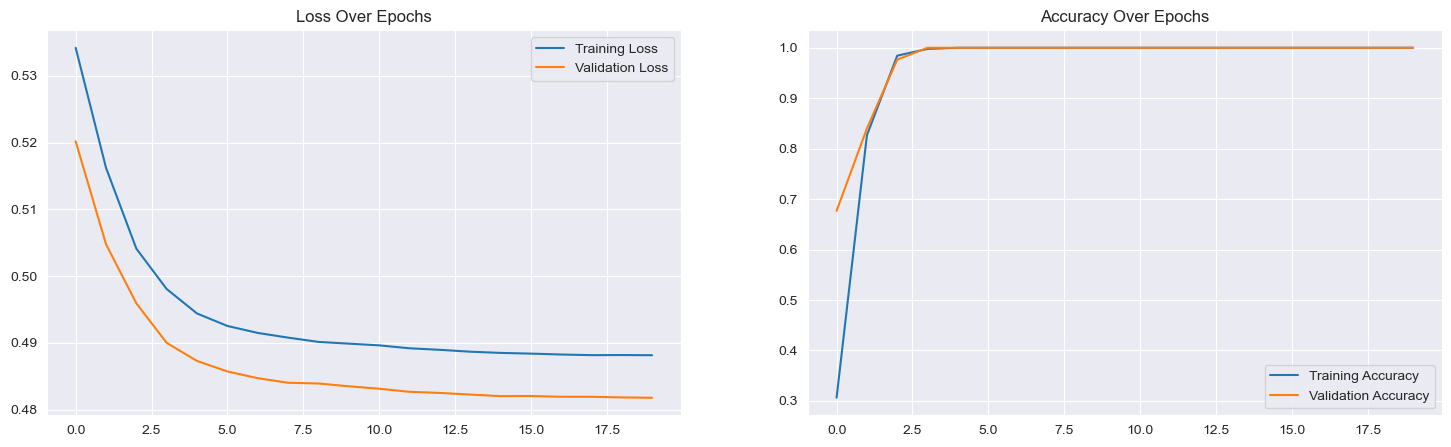

ANN loss: 0.4881456792354584
ANN Validation loss: 0.48176759481430054
ANN accuracy: 1.0
ANN Validation accuracy: 1.0


In [98]:
plot_history(history)
print('ANN loss:', history.history['loss'][-1])
print('ANN Validation loss:', history.history['val_loss'][-1])
print('ANN accuracy:', history.history['accuracy'][-1])
print('ANN Validation accuracy:', history.history['val_accuracy'][-1])

In [99]:
print(f"Accuracy: {custom_accuracy(y_test, mapped_predictions).numpy():.3f}%")

Accuracy: 100.000%


Classify Report of Ensemble Model
     Class  Precision     Recall   F1-Score    ROC AUC    Support
         1       1.00       1.00       1.00       1.00          5
         2       1.00       1.00       1.00       1.00          2
         3       1.00       1.00       1.00       1.00          2
         4       1.00       1.00       1.00       1.00          5
         5       1.00       1.00       1.00       1.00          1
         6       1.00       1.00       1.00       1.00          3
         7       1.00       1.00       1.00       1.00          2
         8       1.00       1.00       1.00       1.00          4
         9       1.00       1.00       1.00       1.00          7
        10       1.00       1.00       1.00       1.00          3
        11       1.00       1.00       1.00       1.00          4
        12       1.00       1.00       1.00       1.00          2
        13       1.00       1.00       1.00       1.00         11
        14       1.00       1.00       1.0

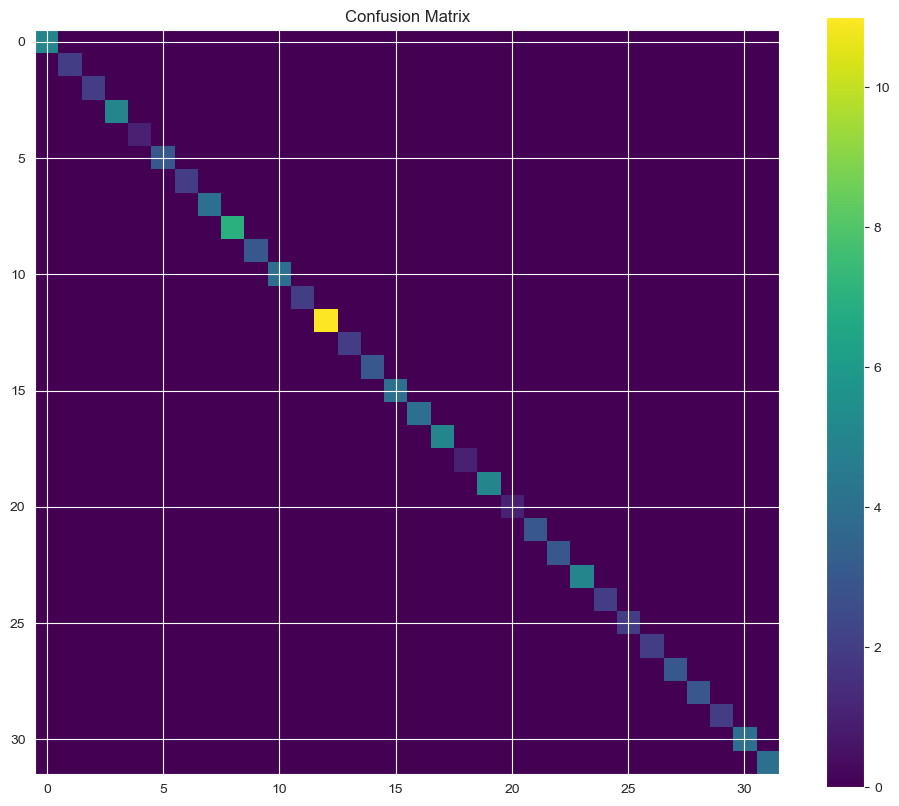

In [63]:
conf_matrix = confusion_matrix(y_test, mapped_predictions)
plt.figure(figsize=(12, 10))
plt.imshow(conf_matrix, cmap='viridis')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()

4/4 [==============================] - 0s 8ms/step


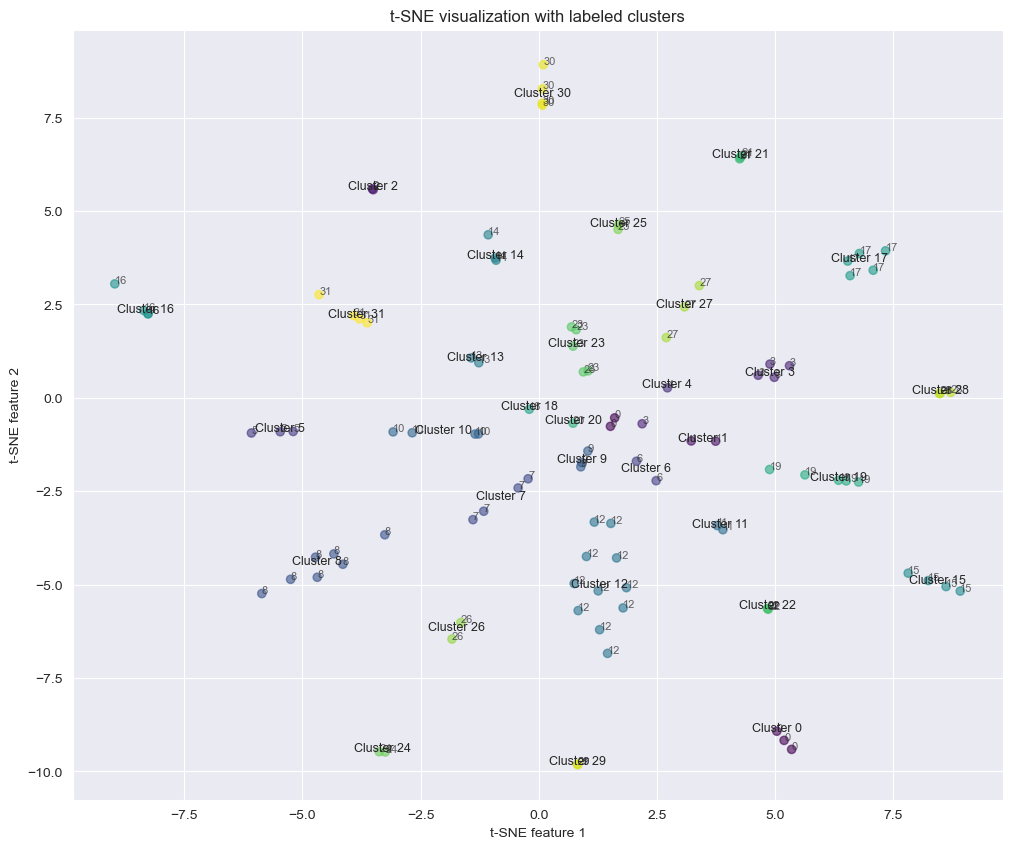

In [64]:
visualize_clusters_with_labels(X_test, mapped_predictions, ann)

# 9. Explainability & Interpretability

In [53]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(32, activation='softmax')
])

In [54]:
model.compile(optimizer='adam', loss=categorical_Entropy_Loss_Function, metrics=[accuracy])

In [55]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10


2023-12-14 13:13:24.071608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 40ms/step - loss: 0.0948 - accuracy: 0.1945
Epoch 2/10
14/14 [==============================] - 0s 12ms/step - loss: 0.0503 - accuracy: 0.6337
Epoch 3/10
14/14 [==============================] - 0s 13ms/step - loss: 0.0244 - accuracy: 0.7983
Epoch 4/10
14/14 [==============================] - 0s 10ms/step - loss: 0.0168 - accuracy: 0.8772
Epoch 5/10
14/14 [==============================] - 0s 11ms/step - loss: 0.0069 - accuracy: 0.9286
Epoch 6/10
14/14 [==============================] - 0s 9ms/step - loss: 0.0014 - accuracy: 0.9955
Epoch 7/10
14/14 [==============================] - 0s 9ms/step - loss: 5.0315e-04 - accuracy: 0.9978
Epoch 8/10
14/14 [==============================] - 0s 13ms/step - loss: 2.7942e-04 - accuracy: 1.0000
Epoch 9/10
14/14 [==============================] - 0s 10ms/step - loss: 1.3685e-04 - accuracy: 1.0000
Epoch 10/10
14/14 [==============================] - 0s 9ms/step - loss: 7.7964e-05 - accuracy: 1.0000


2023-12-14 13:13:40.127284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-14 13:13:41.876225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-14 13:13:43.320626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-14 13:13:44.473894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-14 13:13:45.694251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-14 13:13:47.262399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-12-14 13:13:48.462779: I tensorflow/core/grappler/optimizers/cust

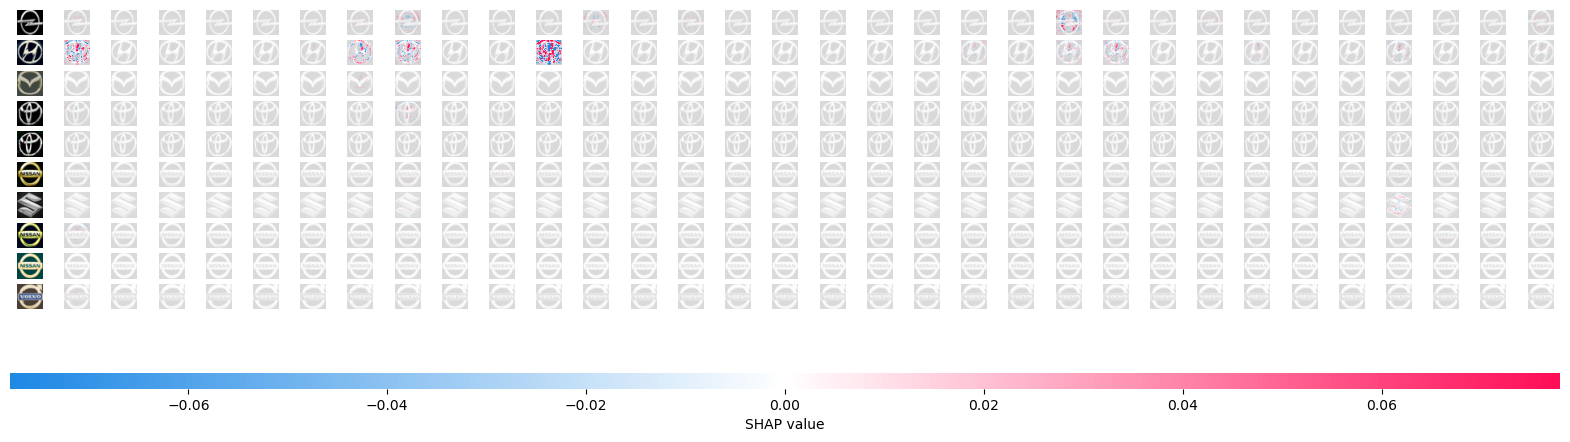

In [56]:
explainer = shap.DeepExplainer(model, X_train[:100])
shap_values = explainer.shap_values(X_test[:10])

shap.image_plot(shap_values, X_test[:10])

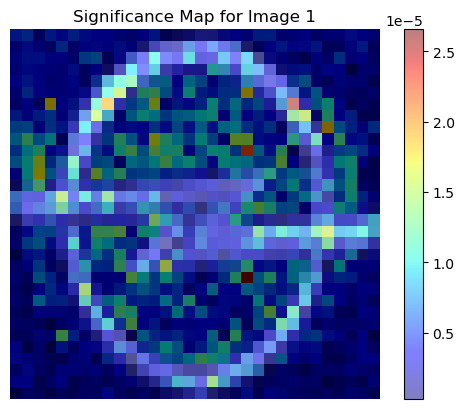

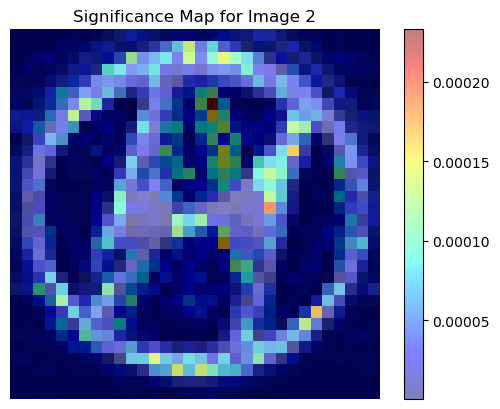

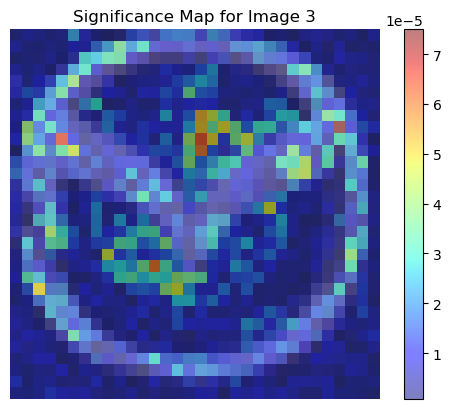

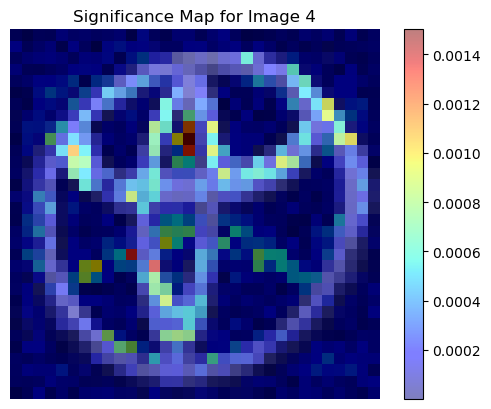

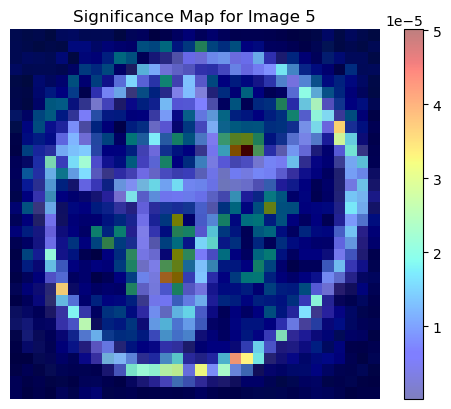

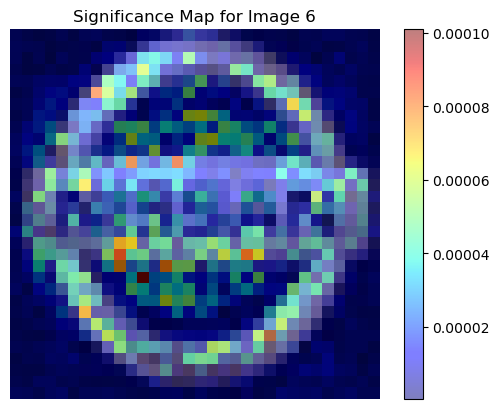

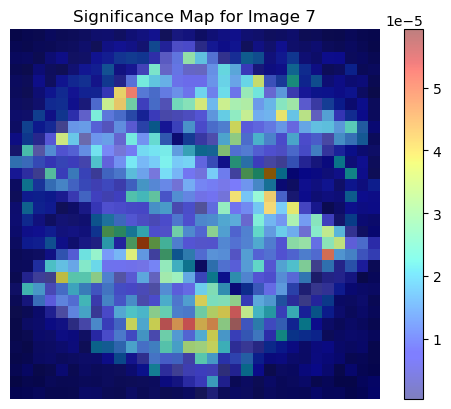

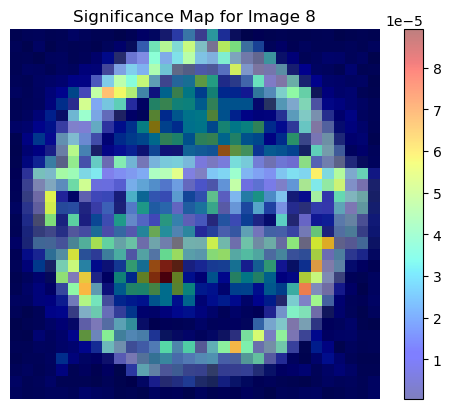

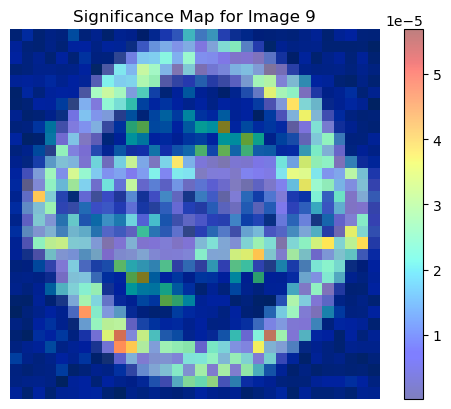

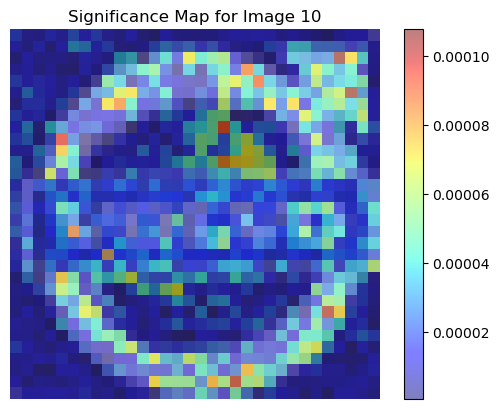

In [60]:
# 生成显著性图
def plot_significance(shap_values, X_test_sample):
    shap_image_vals = np.abs(shap_values[1]).sum(axis=-1)
    for i in range(len(shap_image_vals)):
        plt.imshow(X_test_sample[i], cmap='gray')
        plt.imshow(shap_image_vals[i], cmap='jet', alpha=0.5)
        plt.colorbar()
        plt.title('Significance Map for Image {}'.format(i+1))
        plt.axis('off')
        plt.show()

plot_significance(shap_values, X_test[:10])